# **Introdução - Desafio de Previsão de Sucesso de Startups**


Neste notebook, vamos explorar dados de startups para desenvolver um modelo preditivo capaz de identificar quais têm maior chance de sucesso.

Este é um desafio acadêmico da Inteli, como parte de uma atividade de programação, que combina análise de dados, machine learning e tomada de decisão estratégica para apoiar investidores e aceleradoras.

O conjunto de dados inclui informações sobre histórico de financiamento, localização, setor de atuação, marcos alcançados e conexões estratégicas das startups. A tarefa central é classificação binária, prevendo se uma startup será bem-sucedida (ativa/adquirida) ou não (fechada).

# **Análise Exploratória dos Dados**

##### Importação das bibliotecas


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import FunctionTransformer, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier

##### Carregamento das bases de treino e teste

In [4]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv') 

#### Estrutura do Dataset

**Análise Descritiva**


In [5]:
train_data.describe()

,id,age_first_funding_year,age_last_funding_year,age_first_milestone_year,age_last_milestone_year,relationships,funding_rounds,funding_total_usd,milestones,is_CA,...,is_consulting,is_othercategory,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,labels
count,646.000000,611.000000,637.000000,508.000000,535.000000,646.000000,646.000000,6.460000e+02,646.000000,646.000000,...,646.000000,646.000000,646.000000,646.000000,646.000000,646.000000,646.000000,646.000000,646.000000,646.000000
mean,461.577399,2.341718,4.037724,3.352657,4.944729,7.948916,2.351393,2.949633e+07,1.913313,0.546440,...,0.003096,0.304954,0.329721,0.260062,0.515480,0.419505,0.235294,0.091331,2.848655,0.647059
std,264.859464,2.468275,2.950923,2.866952,3.213319,7.397602,1.357856,2.261999e+08,1.337095,0.498224,...,0.055598,0.460745,0.470476,0.439008,0.500148,0.493860,0.424511,0.288303,1.894050,0.478255
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.100000e+04,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,233.250000,0.680000,1.870000,1.185000,2.540000,3.000000,1.000000,3.000000e+06,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.500000,0.000000
50%,459.500000,1.650000,3.610000,2.785000,4.620000,6.000000,2.000000,1.020000e+07,2.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.333300,1.000000
75%,692.500000,3.600000,5.590000,4.935000,6.880000,10.000000,3.000000,2.587500e+07,3.000000,1.000000,...,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,4.000000,1.000000
max,923.000000,21.900000,21.900000,24.680000,24.680000,63.000000,8.000000,5.700000e+09,6.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,16.000000,1.000000


A tabela acima mostra as estatísticas descritivas do conjunto de dados. Algumas informações importantes são: 

- **Idade e marcos:** as colunas de idade em relação ao primeiro/último financiamento e ao primeiro/último marco apresentam valores médios entre 2 e 5 anos, mas com grande variação (máximo chegando a mais de 20 anos). Isso indica que existem tanto startups muito jovens quanto outras mais consolidadas.
- **Relacionamentos e rodadas de investimento:** em média, cada empresa tem cerca de 8 relacionamentos e 2,3 rodadas de financiamento. O máximo observado foi de 63 relacionamentos e 8 rodadas, mostrando casos de alto networking e captação recorrente.
- **Financiamento total:** há uma grande dispersão em funding_total_usd. O valor médio é em torno de 29 milhões de dólares, mas o desvio padrão é muito alto, chegando a um máximo de 5,7 bilhões. Isso sugere forte assimetria e presença de outliers.
- **Milestones:** a média de marcos atingidos é próxima de 2, com máximo de 6.
- **Variáveis binárias:** indicam se a empresa pertence a determinada categoria ou atingiu uma rodada específica. A média desses campos mostra a proporção de empresas que se enquadram em cada caso. Por exemplo, cerca de 55% são da Califórnia (is_CA), 33% receberam investimento de venture capital (has_VC) e 51% chegaram à rodada A (has_roundA).
- **Participantes médios:** a média é de 2,8 investidores por rodada, com máximo de 16.
- **Labels:** aproximadamente 65% das observações têm rótulo positivo (1).

Em resumo, os dados revelam grande heterogeneidade entre as empresas, especialmente no volume de financiamento. Também fica claro que uma parcela significativa das startups passou por rodadas iniciais de captação (seed e A), mas poucas alcançaram rodadas mais avançadas (C ou D).

**Informações do Dataset**

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 646 entries, 0 to 645
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        646 non-null    int64  
 1   age_first_funding_year    611 non-null    float64
 2   age_last_funding_year     637 non-null    float64
 3   age_first_milestone_year  508 non-null    float64
 4   age_last_milestone_year   535 non-null    float64
 5   relationships             646 non-null    int64  
 6   funding_rounds            646 non-null    int64  
 7   funding_total_usd         646 non-null    int64  
 8   milestones                646 non-null    int64  
 9   is_CA                     646 non-null    int64  
 10  is_NY                     646 non-null    int64  
 11  is_MA                     646 non-null    int64  
 12  is_TX                     646 non-null    int64  
 13  is_otherstate             646 non-null    int64  
 14  category_c

O dataset possui 646 entradas e 33 colunas. A maior parte das variáveis é numérica (`int64` ou `float64`), representando quantidades (ex.: número de rodadas de investimento, relacionamentos, marcos) ou indicadores binários (ex.: "is_CA", "has_VC"). Apenas a coluna "category_code" está no formato `object`, pois representa categorias de empresas em texto. Também é possível notar que algumas colunas do tipo `float64` possuem valores nulos, como "age_first_funding_year", "age_last_funding_year" e "age_first_milestone_year", o que pode exigir tratamento posterior.

**Registros de Amostra**

In [7]:
train_data.head()

,id,age_first_funding_year,age_last_funding_year,age_first_milestone_year,age_last_milestone_year,relationships,funding_rounds,funding_total_usd,milestones,is_CA,...,is_consulting,is_othercategory,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,labels
0,719,10.42,13.09,8.98,12.72,4,3,4087500,3,1,...,0,0,1,1,0,0,0,0,1.0,0
1,429,3.79,3.79,NaN,NaN,21,1,45000000,0,0,...,0,0,0,0,0,1,0,0,1.0,1
2,178,0.71,2.28,1.95,2.28,5,2,5200000,2,1,...,0,1,1,0,1,0,0,0,1.0,0
3,197,3.00,5.00,9.62,10.39,16,2,14500000,2,0,...,0,0,0,1,0,1,0,0,2.0,1
4,444,0.66,5.88,6.21,8.61,29,5,70000000,4,1,...,0,0,0,0,1,1,1,1,2.8,1


**Dimensões e Estrutura do Dataset**

In [8]:
train_data.shape

(646, 33)

##### Colunas

In [9]:
train_data.columns

Index(['id', 'age_first_funding_year', 'age_last_funding_year',
       'age_first_milestone_year', 'age_last_milestone_year', 'relationships',
       'funding_rounds', 'funding_total_usd', 'milestones', 'is_CA', 'is_NY',
       'is_MA', 'is_TX', 'is_otherstate', 'category_code', 'is_software',
       'is_web', 'is_mobile', 'is_enterprise', 'is_advertising',
       'is_gamesvideo', 'is_ecommerce', 'is_biotech', 'is_consulting',
       'is_othercategory', 'has_VC', 'has_angel', 'has_roundA', 'has_roundB',
       'has_roundC', 'has_roundD', 'avg_participants', 'labels'],
      dtype='object')

- **id** (`int64`) → Identificador único da startup no dataset.  

**Variável alvo**
- **labels** (`int64`) → Indicador de sucesso:  
  - **1** = startup bem-sucedida (ativa/adquirida).  
  - **0** = startup fechada/insucesso.  
  - **Distribuição**: ~65% sucesso, ~35% insucesso.  

**Idades relativas (anos desde a fundação até o evento)** 
- **age_first_funding_year** (`float64`) → Anos até o primeiro funding (≥ 0 ou NaN).  
- **age_last_funding_year** (`float64`) → Anos até o último funding (≥ 0 ou NaN).  
- **age_first_milestone_year** (`float64`) → Anos até o primeiro marco relevante (muitos NaN).  
- **age_last_milestone_year** (`float64`) → Anos até o último marco relevante (muitos NaN).  

**Estrutura, histórico e escala de captação**
- **relationships** (`int64`) → Número de relacionamentos (fundadores, executivos, investidores).  
- **funding_rounds** (`int64`) → Número de rodadas de captação.  
- **funding_total_usd** (`float64`) → Total captado em dólares (valores extremos tratados).  
- **milestones** (`int64`) → Quantidade de marcos relevantes registrados.  
- **avg_participants** (`float64`) → Média de investidores por rodada de funding.  

**Localização (variáveis binárias)** 
- **is_CA**, **is_NY**, **is_MA**, **is_TX**, **is_otherstate** (`int64`) → Indicam o estado-sede da startup (Califórnia, Nova Iorque, Massachusetts, Texas ou Outros).  

**Setor/mercado**
- **category_code** (`object`) → Setor principal declarado da startup (string).  
- **is_software**, **is_web**, **is_mobile**, **is_enterprise**, **is_advertising**, **is_gamesvideo**, **is_ecommerce**, **is_biotech**, **is_consulting**, **is_othercategory** (`int64`) → Indicadores de setor em formato binário (0/1).  

**Sinalizadores de financiamento**
- **has_VC** (`int64`) → Recebeu **venture capital**? (0/1).  
- **has_angel** (`int64`) → Recebeu **investimento anjo**? (0/1).  
- **has_roundA**, **has_roundB**, **has_roundC**, **has_roundD** (`int64`) → Indicam se a startup chegou até cada rodada de funding específica.  

#### Identificação das variáveis

As variáveis do dataset foram separadas em três grupos: **numéricas contínuas**, **categóricas** e **binárias**. Essa distinção é importante porque cada tipo de variável demanda um tratamento específico durante a análise e a modelagem.

In [10]:
# Variáveis contínuas
num_continuous = [
    "age_first_funding_year", "age_last_funding_year",
    "age_first_milestone_year", "age_last_milestone_year",
    "funding_total_usd", "avg_participants"
]

# Variáveis discretas de contagem
num_discrete = ["relationships", "funding_rounds", "milestones"]

# Variáveis categóricas nominais
cat_nominal = ["category_code"]

# Variáveis binárias (dummies)
cat_binary = [
    "is_CA", "is_NY", "is_MA", "is_TX", "is_otherstate",
    "is_software", "is_web", "is_mobile", "is_enterprise",
    "is_advertising", "is_gamesvideo", "is_ecommerce", "is_biotech",
    "is_consulting", "is_othercategory",
    "has_VC", "has_angel", "has_roundA", "has_roundB",
    "has_roundC", "has_roundD"
]

# Variável alvo
target = ["labels"]

### Análise da Variável Target

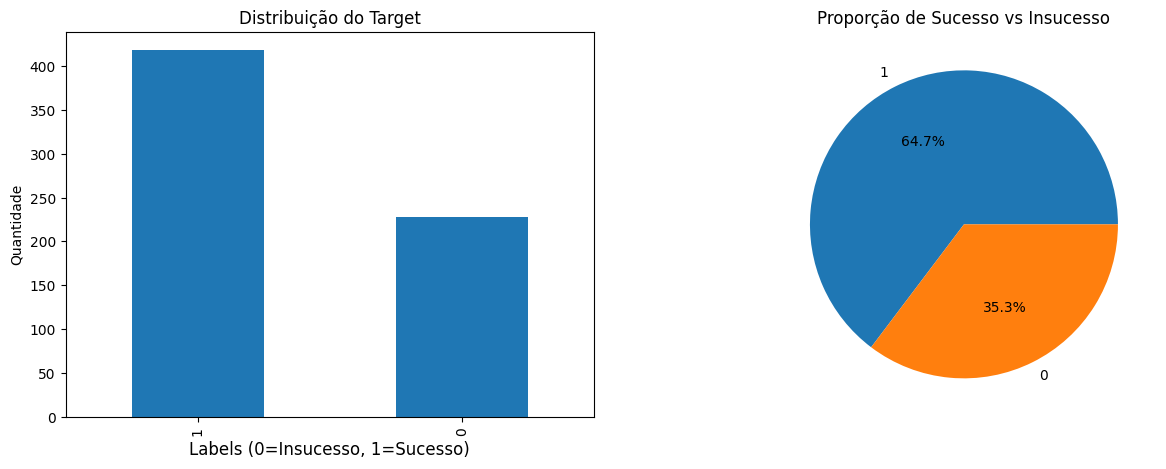

Taxa de sucesso: 64.71%
Dataset relativamente balanceado


In [11]:
# Distribuição do target
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Gráfico de barras
train_data['labels'].value_counts().plot(kind='bar', ax=axes[0])
axes[0].set_title('Distribuição do Target')
axes[0].set_xlabel('Labels (0=Insucesso, 1=Sucesso)', fontsize=12)
axes[0].set_ylabel('Quantidade')

# Gráfico de pizza
train_data['labels'].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%')
axes[1].set_title('Proporção de Sucesso vs Insucesso')
axes[1].set_ylabel('')

plt.show()

# Análise de balanceamento
success_rate = train_data['labels'].mean()
print(f"Taxa de sucesso: {success_rate:.2%}")
if success_rate < 0.3 or success_rate > 0.7:
    print("Dataset desbalanceado")
else:
    print("Dataset relativamente balanceado")

In [12]:
train_data['labels'].value_counts()

labels
1    418
0    228
Name: count, dtype: int64

A variável target representa o desfecho do negócio, sendo:

- 1 = Sucesso
- 0 = Insucesso

No dataset, a distribuição está da seguinte forma:

- Sucesso (1): 64,7%
- Insucesso (0): 35,3%

Essa proporção indica que há mais casos de sucesso do que insucesso, mas a base pode ser considerada relativamente balanceada (não há um desbalanceamento extremo).

O gráfico de barras evidencia que a classe “Sucesso” ocorre quase o dobro de vezes em relação à classe “Insucesso”. Apesar de o desbalanceamento não ser severo, ele deve ser monitorado durante a modelagem e técnicas de tratamento devem ser testadas para entender o comportamento do modelo.

### Análise por Setor

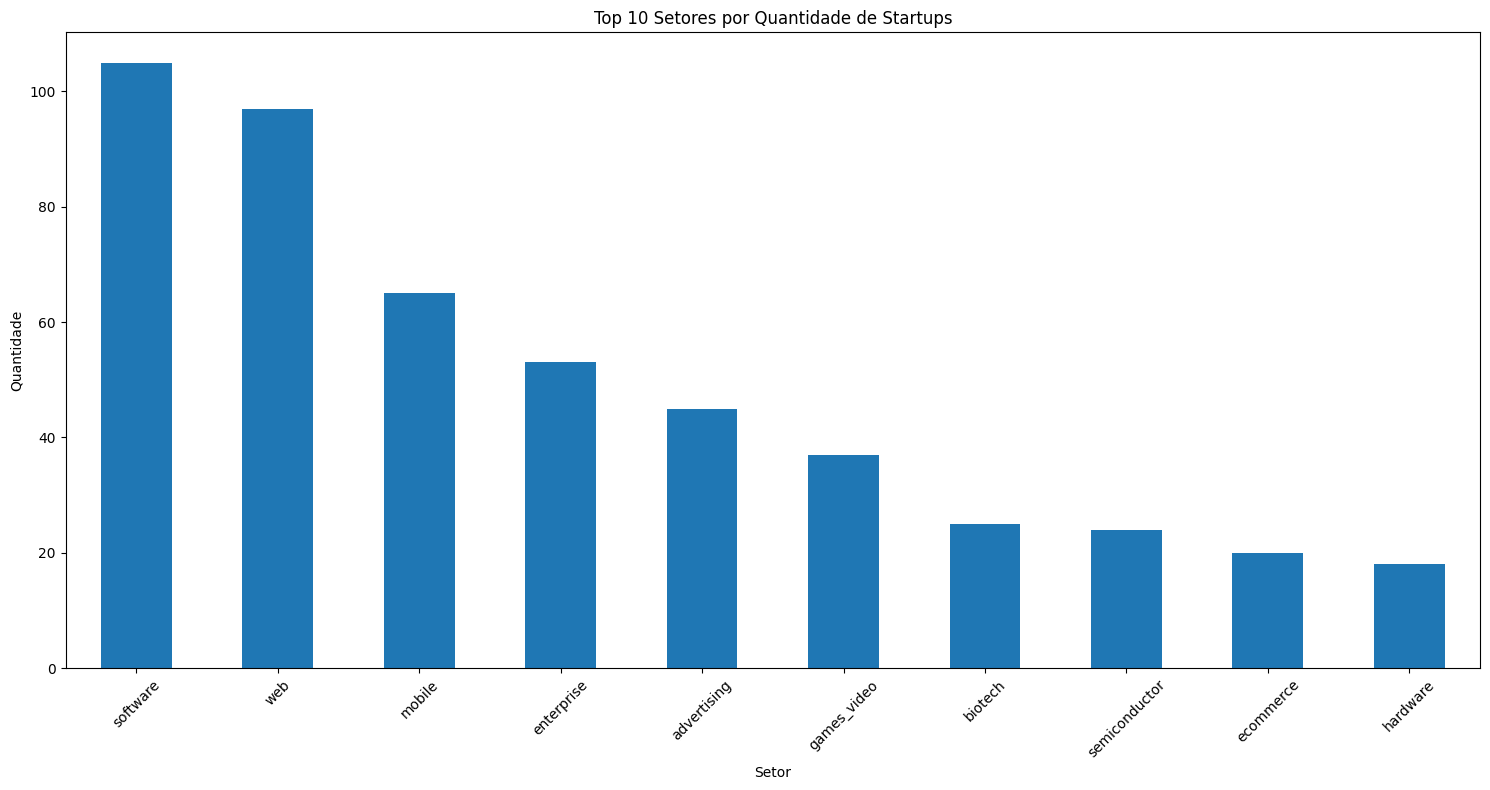

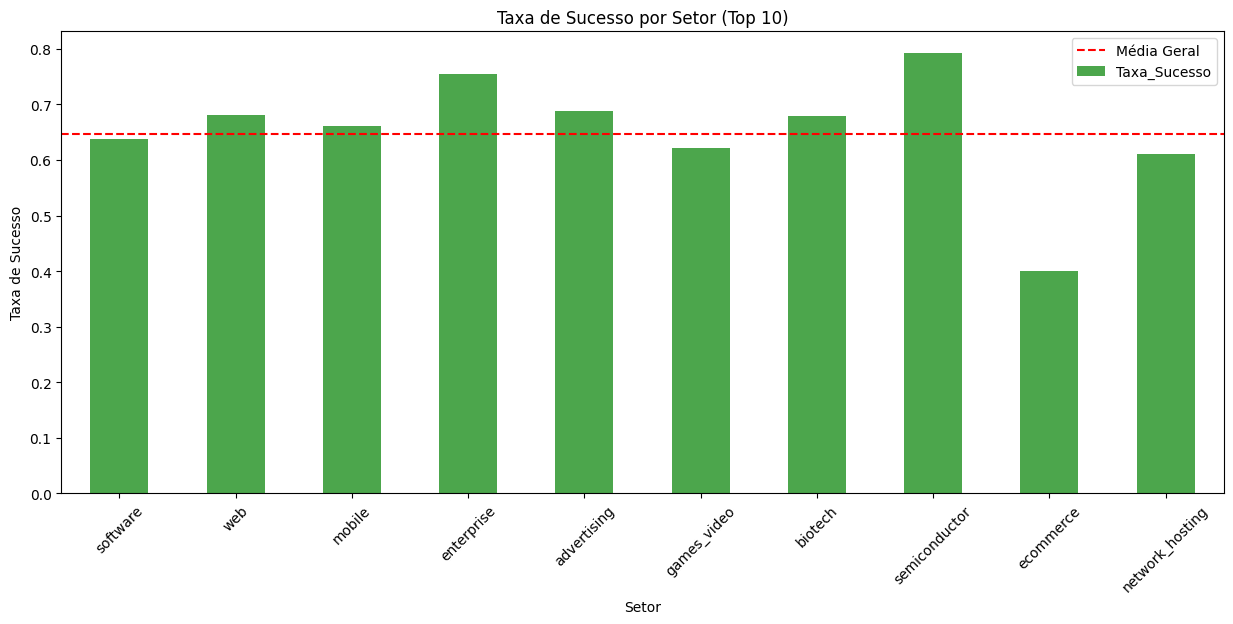

Taxa de sucesso por setor (top 10):
                 Total_Startups  Taxa_Sucesso
category_code                                
software                    105         0.638
web                          97         0.680
mobile                       65         0.662
enterprise                   53         0.755
advertising                  45         0.689
games_video                  37         0.622
biotech                      25         0.680
semiconductor                24         0.792
ecommerce                    20         0.400
network_hosting              18         0.611


In [13]:
# Análise por categoria
plt.figure(figsize=(15, 8))

# Top 10 setores
sector_counts = train_data['category_code'].value_counts().head(10)
sector_counts.plot(kind='bar')
plt.title('Top 10 Setores por Quantidade de Startups')
plt.xlabel('Setor')
plt.ylabel('Quantidade')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Taxa de sucesso por setor (top 10)
sector_success = train_data.groupby('category_code')['labels'].agg(['count', 'mean']).sort_values('count', ascending=False).head(10)
sector_success.columns = ['Total_Startups', 'Taxa_Sucesso']

plt.figure(figsize=(15, 6))
sector_success['Taxa_Sucesso'].plot(kind='bar', color='green', alpha=0.7)
plt.title('Taxa de Sucesso por Setor (Top 10)')
plt.xlabel('Setor')
plt.ylabel('Taxa de Sucesso')
plt.xticks(rotation=45)
plt.axhline(y=train_data['labels'].mean(), color='red', linestyle='--', label='Média Geral')
plt.legend()
plt.show()

print("Taxa de sucesso por setor (top 10):")
print(sector_success.round(3))

Ao observar a taxa de sucesso por setor, percebe-se que Semiconductors (79,2%) e Enterprise (75,5%) se destacam como os segmentos mais promissores, com taxas bem acima da média geral. Setores como Web, Mobile, Advertising e Biotech apresentam desempenho intermediário, próximos de 65% a 69%. Já o E-commerce chama atenção negativamente, com apenas 40% de sucesso, sugerindo alta competitividade e maior risco de insucesso.

Isso indica que o setor é um fator relevante para prever o sucesso de startups, com variações claras entre diferentes segmentos.

### Análise Geográfica

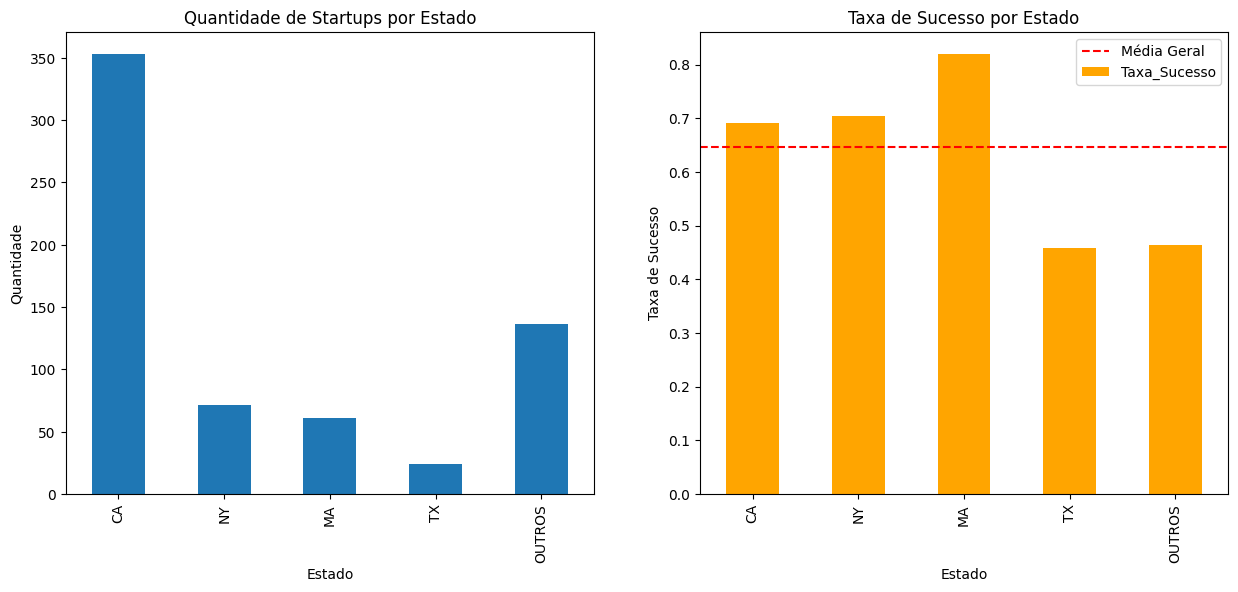

Análise geográfica:
   Estado  Total  Taxa_Sucesso
0      CA    353         0.691
1      NY     71         0.704
2      MA     61         0.820
3      TX     24         0.458
4  OUTROS    136         0.463


In [14]:
# Análise por localização
location_cols = ['is_CA', 'is_NY', 'is_MA', 'is_TX', 'is_otherstate']
location_data = []

for col in location_cols:
    state = col.replace('is_', '').upper()
    if state == 'OTHERSTATE':
        state = 'OUTROS'
    
    total = train_data[col].sum()
    success_rate = train_data[train_data[col] == 1]['labels'].mean()
    location_data.append({'Estado': state, 'Total': total, 'Taxa_Sucesso': success_rate})

location_df = pd.DataFrame(location_data)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Quantidade por estado
location_df.set_index('Estado')['Total'].plot(kind='bar', ax=axes[0])
axes[0].set_title('Quantidade de Startups por Estado')
axes[0].set_ylabel('Quantidade')

# Taxa de sucesso por estado
location_df.set_index('Estado')['Taxa_Sucesso'].plot(kind='bar', ax=axes[1], color='orange')
axes[1].set_title('Taxa de Sucesso por Estado')
axes[1].set_ylabel('Taxa de Sucesso')
axes[1].axhline(y=train_data['labels'].mean(), color='red', linestyle='--', label='Média Geral')
axes[1].legend()

plt.show()

print("Análise geográfica:")
print(location_df.round(3))

Na análise por localização, observa-se que Massachusetts (MA) apresenta a maior taxa de sucesso (82%), indicando um ecossistema favorável apesar do número reduzido de startups. Nova York (70,4%) e Califórnia (69,1%) também se destacam, reforçando sua importância como polos de inovação. Em contrapartida, Texas (45,8%) e o grupo de Outros estados (46,3%) apresentam desempenho bem abaixo, o que pode indicar ambientes menos estruturados para o crescimento de startups.

### Análise das Variáveis Financeiras

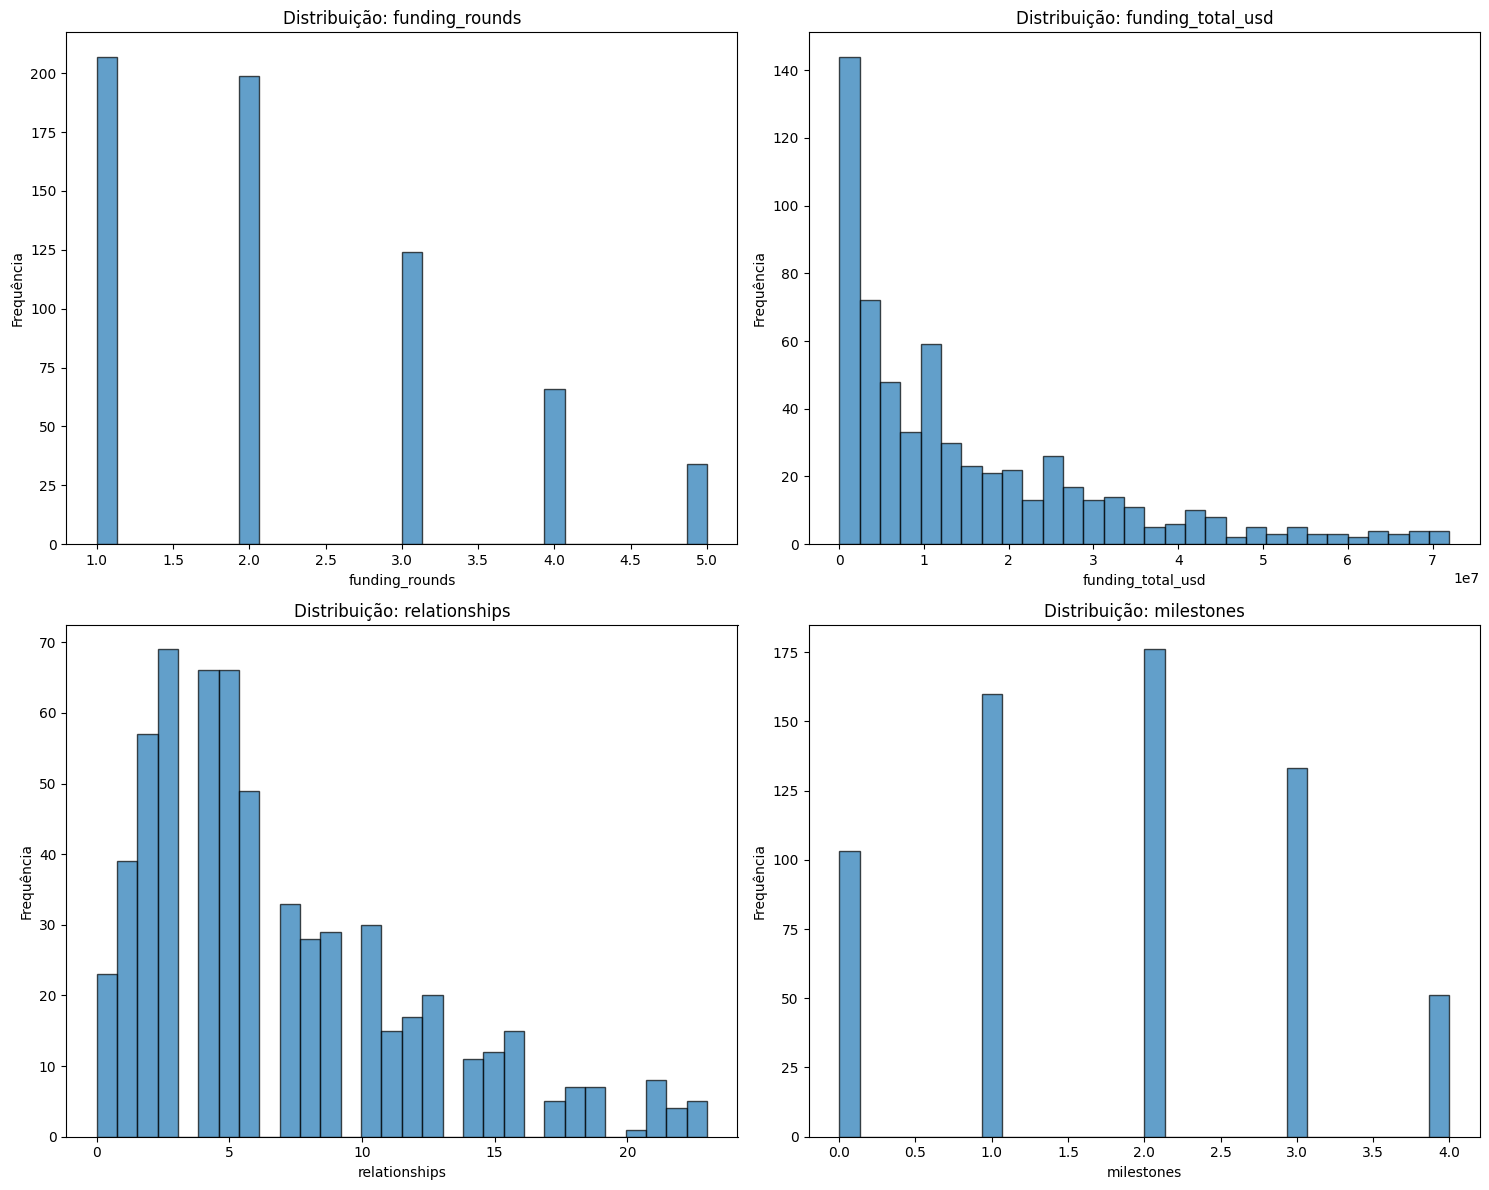


 Correlação com sucesso:
labels               1.000
relationships        0.343
milestones           0.335
funding_rounds       0.213
funding_total_usd    0.044
Name: labels, dtype: float64


In [15]:
# Análise das variáveis financeiras
financial_cols = ['funding_rounds', 'funding_total_usd', 'relationships', 'milestones']

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(financial_cols):
    # Remover outliers extremos para visualização
    data = train_data[col].dropna()
    q95 = data.quantile(0.95)
    data_clean = data[data <= q95]
    
    axes[i].hist(data_clean, bins=30, alpha=0.7, edgecolor='black')
    axes[i].set_title(f'Distribuição: {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequência')

plt.tight_layout()
plt.show()

# Correlação entre variáveis financeiras e sucesso
print("\n Correlação com sucesso:")
financial_corr = train_data[financial_cols + ['labels']].corr()['labels'].sort_values(ascending=False)
print(financial_corr.round(3))

A correlação mostra que variáveis financeiras ligadas ao engajamento e progressão da startup têm maior relação com o sucesso. O número de relacionamentos (0,343) e de milestones (0,335) são os principais fatores associados, sugerindo que conexões estratégicas e conquistas intermediárias influenciam fortemente os resultados. O número de rodadas de investimento (0,213) também apresenta relação positiva, ainda que mais moderada.

Já o valor total captado (0,044) quase não tem correlação, indicando que apenas captar grandes quantias não garante sucesso. O impacto vem mais da trajetória (rodadas, milestones) e do capital social (relacionamentos) do que do volume financeiro isolado.

### Análise Temporal

C:\Users\Inteli.NOTEBOOK-0456\AppData\Local\Temp\ipykernel_14224\2741344652.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_faixas = train_data.groupby("faixa_funding").agg(


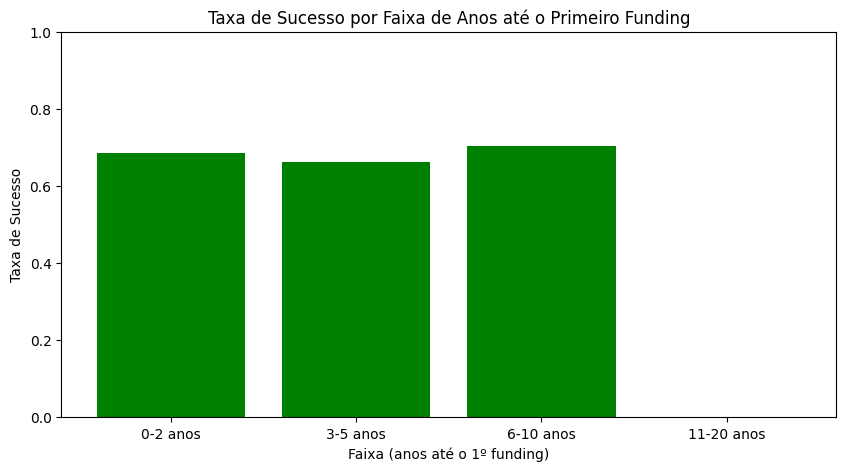

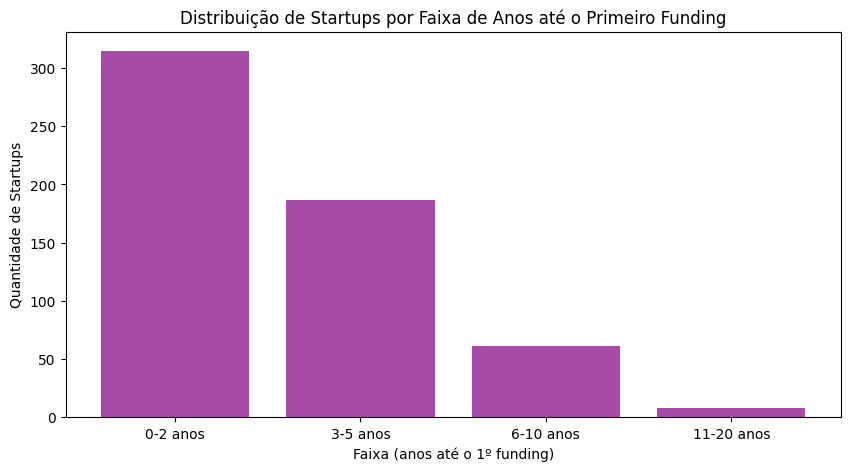

Evolução temporal (primeiro funding):
  faixa_funding  Total_Startups  Taxa_Sucesso
0      0-2 anos             315      0.685714
1      3-5 anos             187      0.663102
2     6-10 anos              61      0.704918
3    11-20 anos               8      0.000000


In [16]:
# --- Agrupar idade do primeiro funding em faixas ---
bins = [0, 2, 5, 10, 20]  
labels = ["0-2 anos", "3-5 anos", "6-10 anos", "11-20 anos"]

train_data["faixa_funding"] = pd.cut(train_data["age_first_funding_year"], bins=bins, labels=labels)

# Calcular taxa de sucesso e total de startups por faixa
df_faixas = train_data.groupby("faixa_funding").agg(
    Total_Startups=("labels", "count"),
    Taxa_Sucesso=("labels", "mean")
).reset_index()

# --- Gráfico: Taxa de sucesso por faixa ---
plt.figure(figsize=(10,5))
plt.bar(df_faixas["faixa_funding"], df_faixas["Taxa_Sucesso"], color="green")
plt.title("Taxa de Sucesso por Faixa de Anos até o Primeiro Funding")
plt.ylabel("Taxa de Sucesso")
plt.xlabel("Faixa (anos até o 1º funding)")
plt.ylim(0,1)
plt.show()

# --- Gráfico: Total de startups por faixa ---
plt.figure(figsize=(10,5))
plt.bar(df_faixas["faixa_funding"], df_faixas["Total_Startups"], color="purple", alpha=0.7)
plt.title("Distribuição de Startups por Faixa de Anos até o Primeiro Funding")
plt.ylabel("Quantidade de Startups")
plt.xlabel("Faixa (anos até o 1º funding)")
plt.show()

# Exibir tabela
print("Evolução temporal (primeiro funding):")
print(df_faixas.head(10))

Ao observar a evolução temporal do primeiro aporte, percebe-se que a maioria das startups recebe investimentos iniciais nos primeiros 2 anos de existência, apresentando uma taxa de sucesso de ~68,6%. Esse valor se mantém relativamente alto também no grupo de 3 a 5 anos (~66,3%).

Já startups que recebem funding entre 6 e 10 anos mostram até uma taxa ligeiramente superior (~70,5%), sugerindo que empresas mais resilientes conseguem bons resultados mesmo com capital tardio.

Já as poucas que receberam aportes apenas entre 11 e 20 anos não demonstraram sucesso, possivelmente por já estarem maduras demais ou sem tração significativa antes do investimento.

Em conclusão, é possível perceber que o timing do investimento é crucial no sucesso: quanto mais cedo, maior a chance de sucesso, entretanto há espaço para exceções em empresas que se consolidam antes de captar.

## Hipóteses

**Hipótese 1 – Localização Geográfica:**

Startups localizadas em Massachusetts (MA) apresentam maior chance de sucesso em comparação com outros estados. Isso pode estar relacionado ao ambiente de inovação e ao acesso privilegiado a universidades, investidores e redes de apoio na região.

Taxa de sucesso por estado:
is_CA: 69.12%
is_NY: 70.42%
is_MA: 81.97%
is_TX: 45.83%
is_otherstate: 46.32%


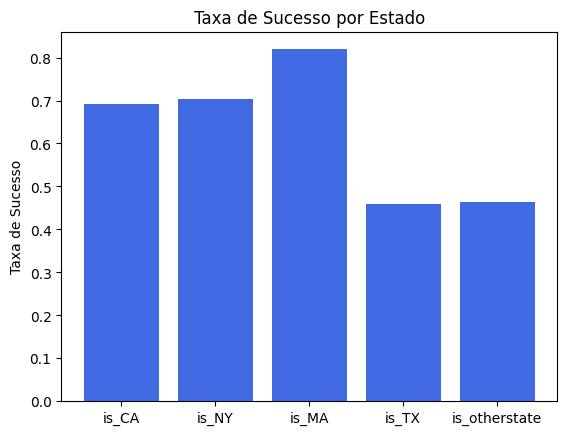

In [17]:
# Média de sucesso por estado (variáveis dummy)
estados = ["is_CA", "is_NY", "is_MA", "is_TX", "is_otherstate"]
taxas_estado = {estado: train_data.loc[train_data[estado] == 1, "labels"].mean() for estado in estados}

print("Taxa de sucesso por estado:")
for estado, taxa in taxas_estado.items():
    print(f"{estado}: {taxa:.2%}")

# Visualização
plt.bar(taxas_estado.keys(), taxas_estado.values(), color="royalblue")
plt.title("Taxa de Sucesso por Estado")
plt.ylabel("Taxa de Sucesso")
plt.show()

Os resultados confirmam de forma consistente a hipóteses formulada. Startups em Massachusetts (MA) se destacam com a maior taxa de sucesso (81,97%), reforçando a influência de ecossistemas consolidados sobre o desempenho das empresas. 

**Hipótese 2 – Estrutura de Relacionamentos:**

Startups com um número maior de relacionamentos registrados tendem a apresentar maior taxa de sucesso. Isso porque conexões estratégicas podem indicar acesso a parceiros, clientes e investidores, aumentando as chances de crescimento.

Taxa de sucesso por número de relacionamentos:
rel_group
0-5      0.505051
6-10     0.757396
11-20    0.863636
21-50    0.913043
50+      1.000000
Name: labels, dtype: float64


C:\Users\Inteli.NOTEBOOK-0456\AppData\Local\Temp\ipykernel_14224\1655871908.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sucesso_rel = train_data.groupby("rel_group")["labels"].mean()


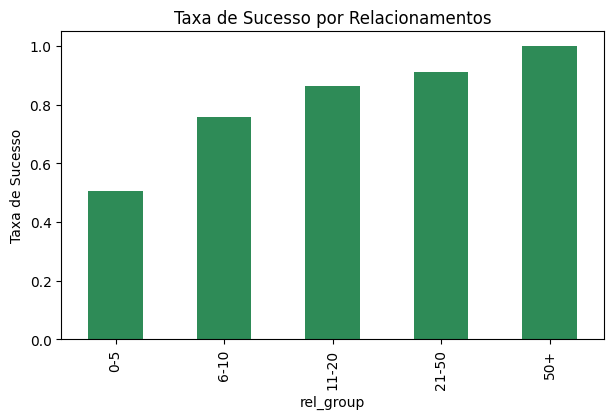

In [18]:
# Criar faixas de relacionamentos
train_data["rel_group"] = pd.cut(
    train_data["relationships"],
    bins=[0, 5, 10, 20, 50, train_data["relationships"].max()],
    labels=["0-5", "6-10", "11-20", "21-50", "50+"]
)

sucesso_rel = train_data.groupby("rel_group")["labels"].mean()

print("Taxa de sucesso por número de relacionamentos:")
print(sucesso_rel)

# Visualização
sucesso_rel.plot(kind="bar", color="seagreen", figsize=(7,4))
plt.title("Taxa de Sucesso por Relacionamentos")
plt.ylabel("Taxa de Sucesso")
plt.show()

Os resultados confirmam de forma consistente a hipóteses formulada. É possível observar no gráfico que quanto maior o número de relacionamentos registrados, maior a taxa de sucesso, chegando a mais de 90% para startups com mais de 20 conexões, o que valida a importância de redes estratégicas.

**Hipótese 3 – Tempo até o Primeiro Funding**

Startups que recebem seu primeiro funding mais cedo (menor idade no primeiro funding) têm maior probabilidade de sucesso. Esse fator pode refletir agilidade em captar recursos, sinalizando maior confiança do mercado no potencial da empresa.

Taxa de sucesso por idade no 1º funding:
funding_age_group
0-2 anos      0.662890
3-5 anos      0.663102
6-10 anos     0.704918
11-20 anos    0.000000
20+ anos      0.000000
Name: labels, dtype: float64


C:\Users\Inteli.NOTEBOOK-0456\AppData\Local\Temp\ipykernel_14224\539310072.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sucesso_funding_age = train_data.groupby("funding_age_group")["labels"].mean()


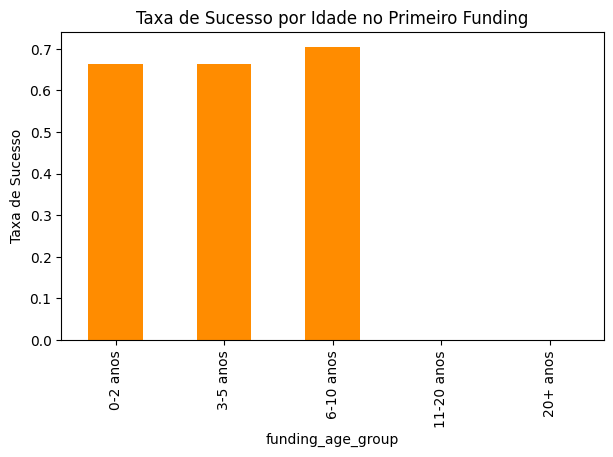

In [19]:
# Criar faixas de idade no primeiro funding
train_data["funding_age_group"] = pd.cut(
    train_data["age_first_funding_year"],
    bins=[-1, 2, 5, 10, 20, 50],
    labels=["0-2 anos", "3-5 anos", "6-10 anos", "11-20 anos", "20+ anos"]
)

sucesso_funding_age = train_data.groupby("funding_age_group")["labels"].mean()

print("Taxa de sucesso por idade no 1º funding:")
print(sucesso_funding_age)

# Visualização
sucesso_funding_age.plot(kind="bar", color="darkorange", figsize=(7,4))
plt.title("Taxa de Sucesso por Idade no Primeiro Funding")
plt.ylabel("Taxa de Sucesso")
plt.show()


Os resultados confirmam de forma consistente a hipótese formulada. A análise temporal mostrou que captar funding cedo está associado a maiores taxas de sucesso, especialmente dentro dos primeiros 10 anos, confirmando a relevância da agilidade em atrair investimento inicial, embora não exista vantagem clara em captar nos primeiros 2–5 anos em relação a até 10 anos.

# **Pré-processamento de Dados**

### Tratamento de Valores Nulos

A ausência de dados pode afetar o desempenho e a qualidade das previsões, além de indicar possíveis vieses. Assim, foi realizada uma verificação da quantidade e proporção de valores ausentes em cada variável, para então definir a estratégia de tratamento adequada.

In [20]:
# --- Valores nulos no treino ---
null_train = train_data.isnull().sum()
null_train_pct = (null_train / len(train_data)) * 100

df_train = pd.DataFrame({
    "Nulos Treino (Qtd)": null_train,
    "Nulos Treino (%)": null_train_pct
})

# Filtrar apenas colunas com nulos
df_train = df_train[df_train["Nulos Treino (Qtd)"] > 0] \
    .sort_values(by="Nulos Treino (%)", ascending=False)

print("Valores nulos no conjunto de TREINO:")
display(df_train)

# --- Valores nulos no teste ---
null_test = test_data.isnull().sum()
null_test_pct = (null_test / len(test_data)) * 100

df_test = pd.DataFrame({
    "Nulos Teste (Qtd)": null_test,
    "Nulos Teste (%)": null_test_pct
})

# Filtrar apenas colunas com nulos
df_test = df_test[df_test["Nulos Teste (Qtd)"] > 0] \
    .sort_values(by="Nulos Teste (%)", ascending=False)

print("Valores nulos no conjunto de TESTE:")
display(df_test)

Valores nulos no conjunto de TREINO:


,Nulos Treino (Qtd),Nulos Treino (%)
age_first_milestone_year,138,21.362229
age_last_milestone_year,111,17.182663
faixa_funding,75,11.609907
funding_age_group,35,5.417957
age_first_funding_year,35,5.417957
rel_group,23,3.560372
age_last_funding_year,9,1.393189


Valores nulos no conjunto de TESTE:


,Nulos Teste (Qtd),Nulos Teste (%)
age_first_milestone_year,60,21.660650
age_last_milestone_year,53,19.133574
age_first_funding_year,11,3.971119
age_last_funding_year,4,1.444043


A análise inicial revelou a presença de valores nulos, concentrados principalmente em variáveis relacionadas a eventos temporais (`age_*`). As proporções de dados ausentes são semelhantes entre treino e teste, indicando um padrão consistente de missing.

Para lidar com esses valores ausentes de forma adequada e evitar vazamento de informação, eles serão tratados diretamente no pipeline de pré-processamento, aplicando imputação consistente tanto no conjunto de treinamento quanto em dados novos.

In [21]:
# Colunas numéricas e categóricas
numeric_cols = train_data.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = train_data.select_dtypes(include=['object', 'category']).columns.tolist()

# --- Tratamento ---
# Numéricos -> mediana
for col in numeric_cols:
    median_val = train_data[col].median()
    train_data[col] = train_data[col].fillna(median_val)
    if col in test_data.columns:
        test_data[col] = test_data[col].fillna(median_val)

# Categóricos -> moda
for col in cat_cols:
    mode_val = train_data[col].mode()[0]
    train_data[col] = train_data[col].fillna(mode_val)
    if col in test_data.columns:
        test_data[col] = test_data[col].fillna(mode_val)

print("Valores nulos após tratamento (train):", train_data.isnull().sum().sum())
print("Valores nulos após tratamento (test):", test_data.isnull().sum().sum())

Valores nulos após tratamento (train): 0
Valores nulos após tratamento (test): 0


Os valores nulos foram tratados com a imputação de mediana nos valores numéricos e com a imputação da moda nos valores categóricos. 

Durante a análise, percebeu-se que a ausência de valores nas colunas `age*` significavam que a startup não se desenvolveu e que isso poderia ser um fator significativo para medir o fracasso da startup. Desse modo, tentou-se imputar o valor de -1, entertanto isso diminuiu a acurácia do modelo, então o código foi retirado.

In [22]:
""""
# --- 1. Substituir 'ages' faltantes por -1 ---
age_cols = ["age_first_milestone_year", "age_last_milestone_year", 
            "age_first_funding_year", "age_last_funding_year"]

for col in age_cols:
    if col in train_data.columns:
        train_data[col] = train_data[col].fillna(-1)
    if col in test_data.columns:
        test_data[col] = test_data[col].fillna(-1)

# --- 2. Numéricas restantes -> mediana ---
num_cols = train_data.select_dtypes(include=["int64", "float64"]).columns.tolist()

# remover a coluna de label se estiver em num_cols
if "labels" in num_cols:
    num_cols.remove("labels")

imputer_num = SimpleImputer(strategy="median")
train_data[num_cols] = imputer_num.fit_transform(train_data[num_cols])
test_data[num_cols] = imputer_num.transform(test_data[num_cols])

# --- 3. Categóricas -> moda (valor mais frequente) ---
cat_cols = train_data.select_dtypes(include=["object", "category"]).columns

imputer_cat = SimpleImputer(strategy="most_frequent")
train_data[cat_cols] = imputer_cat.fit_transform(train_data[cat_cols])
test_data[cat_cols] = imputer_cat.transform(test_data[cat_cols])
"""

'"\n# --- 1. Substituir \'ages\' faltantes por -1 ---\nage_cols = ["age_first_milestone_year", "age_last_milestone_year", \n            "age_first_funding_year", "age_last_funding_year"]\n\nfor col in age_cols:\n    if col in train_data.columns:\n        train_data[col] = train_data[col].fillna(-1)\n    if col in test_data.columns:\n        test_data[col] = test_data[col].fillna(-1)\n\n# --- 2. Numéricas restantes -> mediana ---\nnum_cols = train_data.select_dtypes(include=["int64", "float64"]).columns.tolist()\n\n# remover a coluna de label se estiver em num_cols\nif "labels" in num_cols:\n    num_cols.remove("labels")\n\nimputer_num = SimpleImputer(strategy="median")\ntrain_data[num_cols] = imputer_num.fit_transform(train_data[num_cols])\ntest_data[num_cols] = imputer_num.transform(test_data[num_cols])\n\n# --- 3. Categóricas -> moda (valor mais frequente) ---\ncat_cols = train_data.select_dtypes(include=["object", "category"]).columns\n\nimputer_cat = SimpleImputer(strategy="most_fr

### Duplicatas

In [23]:
print(train_data.duplicated().sum(),'duplicatas')
print(test_data.duplicated().sum(),'duplicatas')

0 duplicatas
0 duplicatas


O código acima verifica a existência de linhas duplicadas na base de dados, como não existem, segue-se a limpeza.

### Outliers

In [24]:
# Selecionar apenas colunas numéricas
numeric_cols = train_data.select_dtypes(include=[np.number]).columns

outlier_summary = {}

for col in numeric_cols:
    Q1 = train_data[col].quantile(0.25)
    Q3 = train_data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    # Contar outliers
    n_outliers = ((train_data[col] < lower) | (train_data[col] > upper)).sum()
    pct_outliers = n_outliers / len(train_data) * 100
    
    if n_outliers > 0:  # salvar só colunas que têm outliers
        outlier_summary[col] = {
            "Qtd Outliers": n_outliers,
            "% Outliers": round(pct_outliers, 2)
        }

df_outliers = pd.DataFrame(outlier_summary).T.sort_values("% Outliers", ascending=False)

print("Resumo de outliers por variável (IQR):")
display(df_outliers)

Resumo de outliers por variável (IQR):


,Qtd Outliers,% Outliers
has_roundC,152.0,23.53
is_otherstate,136.0,21.05
is_software,105.0,16.25
is_web,97.0,15.02
is_NY,71.0,10.99
is_mobile,65.0,10.06
is_MA,61.0,9.44
has_roundD,59.0,9.13
is_enterprise,53.0,8.20
funding_total_usd,50.0,7.74


A aplicação do método do Intervalo Interquartil (IQR) revelou a presença de valores atípicos em diversas variáveis. A análise desses resultados distingue os "falsos positivos" (outliers não problemáticos) e outliers verdadeiros (que podem interferir na modelagem).


**1. Falsos Outliers (Variáveis Binárias)**

| Variável | Característica | Implicação |
|----------|----------------|------------|
| has_roundC, is_otherstate, is_software, is_web | Variáveis binárias (0 ou 1) com alta proporção de "outliers". | Não preocupante. O método IQR não é adequado para este tipo de variável, gerando falsos positivos (artefatos do cálculo). Esses valores não serão tratados. |


**2. Outliers Relevantes (Variáveis Financeiras e de Atividade)**

Os outliers observados nestas variáveis são significativos e refletem características reais e valiosas das empresas.

| Variável | Proporção de Outliers | Interpretação e Recomendação de Tratamento |
|----------|---------------------|-------------------------------------------|
| funding_total_usd | 7,7% | Representam empresas que receberam rodadas de investimento excepcionais. |
| relationships | 7,3% | Indicam empresas com redes de contato ou parcerias muito acima da média do grupo. |

Estes valores são informações valiosas sobre o sucesso ou a dimensão das startups e não devem ser simplesmente removidos. O tratamento ideal deve focar em reduzir o impacto da escala sem perder a informação, por meio de:  

- **Transformações Logarítmicas:** Para normalizar a distribuição e mitigar a influência dos valores extremos.  
- **Modelos Robustos:** Utilização de algoritmos de machine learning que são menos sensíveis a outliers.  


**3. Outliers em Métricas de Rodadas e Idade**

Outras métricas apresentaram um nível de outliers mais gerenciável, mas que também merecem atenção.

- **Métricas de Rodadas (<3% de outliers):** Variáveis como `funding_rounds` e `avg_participants` refletem startups com um histórico de captação de investimento ou um padrão de participação em rodadas incomum. O tratamento via transformação logarítmica também é recomendado.

- **Variáveis de Idade (<2% de outliers):** O baixo percentual de valores atípicos nas variáveis `age_*` sugere que a idade das empresas está, em geral, bem distribuída, necessitando de intervenção mínima.


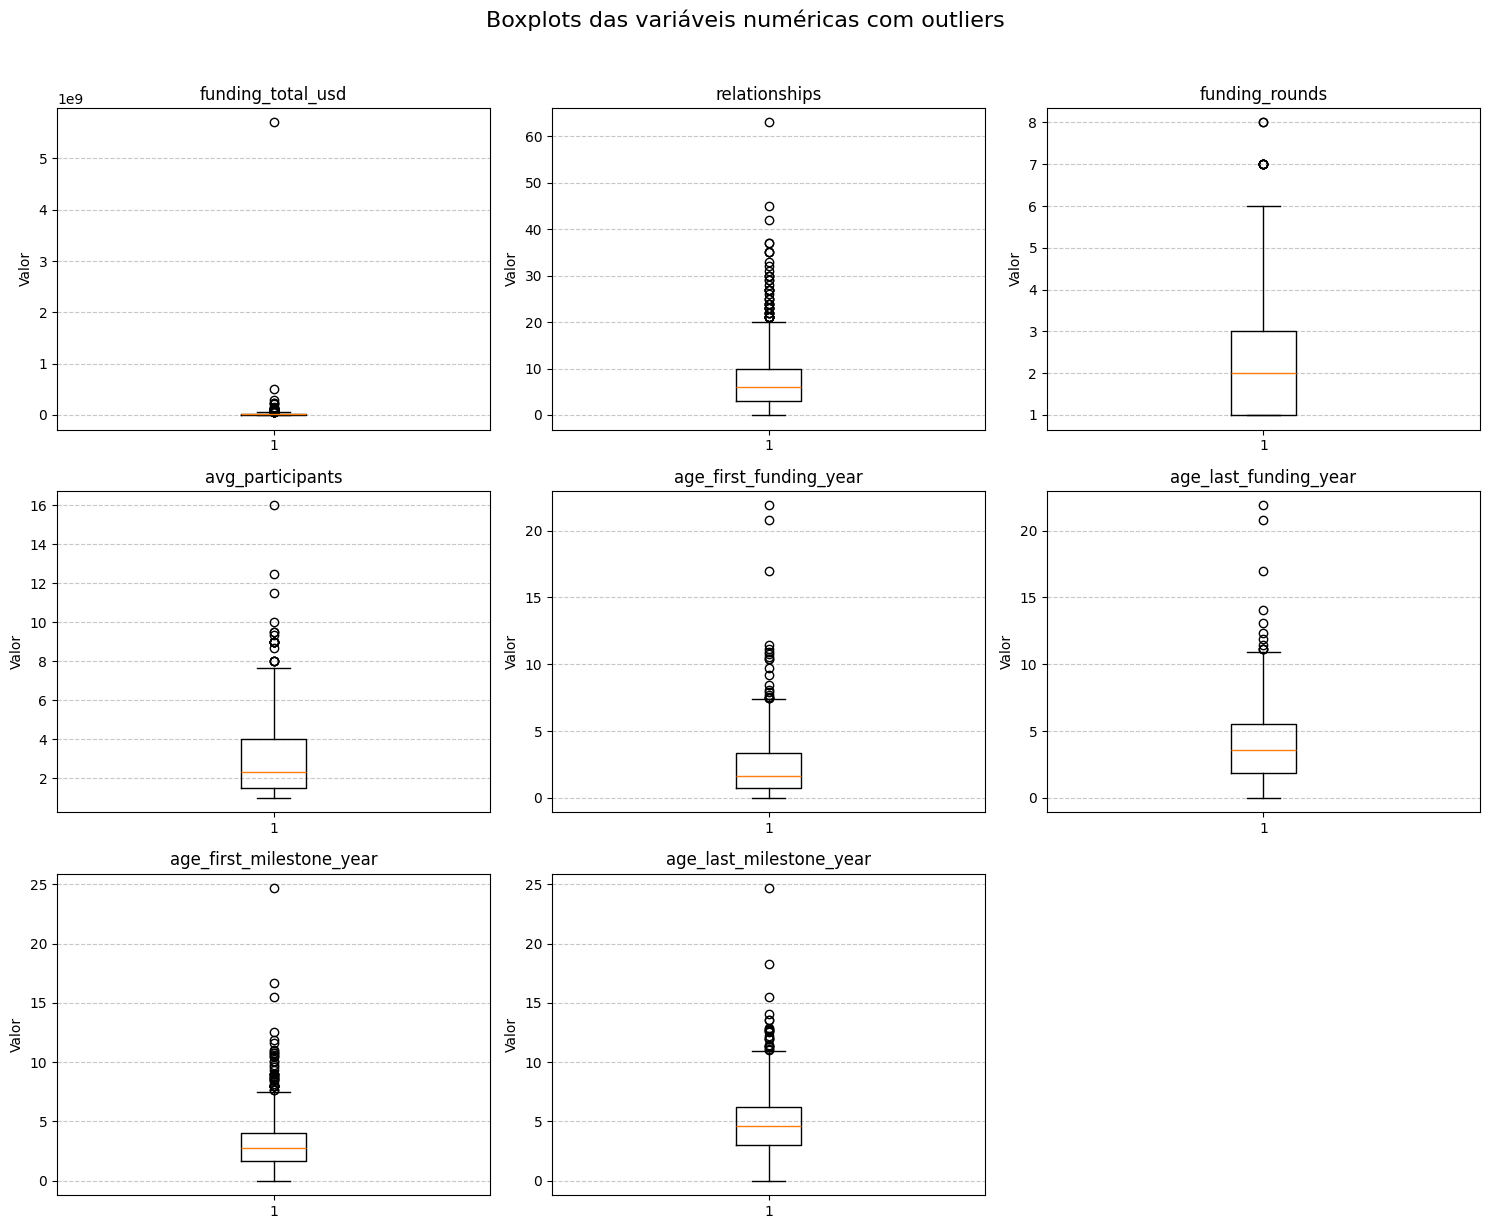

In [25]:
# Selecionar colunas com outliers reais (tirando as binárias)
cols_outliers = [
    "funding_total_usd",
    "relationships",
    "funding_rounds",
    "avg_participants",
    "age_first_funding_year",
    "age_last_funding_year",
    "age_first_milestone_year",
    "age_last_milestone_year"
]

# Plotar boxplots
n_cols = 3
n_rows = int(np.ceil(len(cols_outliers) / n_cols))

plt.figure(figsize=(15, n_rows*4))

for i, col in enumerate(cols_outliers, 1):
    plt.subplot(n_rows, n_cols, i)
    plt.boxplot(train_data[col].dropna(), vert=True)
    plt.title(col)
    plt.ylabel("Valor")
    plt.grid(True, axis="y", linestyle="--", alpha=0.7)

plt.suptitle("Boxplots das variáveis numéricas com outliers", fontsize=16, y=1.02)
plt.tight_layout()

plt.show()

A análise anterior identificou valores extremos (outliers) em variáveis numéricas, que poderiam distorcer a modelagem e prejudicar a performance dos algoritmos.

nicialmente, foi testado o método de remoção de outliers baseado no Intervalo Interquartil (IQR) com winsorização, que limita os valores extremos aos limites do IQR. No entanto, essa abordagem não trouxe melhorias significativas na acurácia e apresentou dificuldades ao lidar com algumas variáveis, complicando a análise.

In [26]:
"""
train_out = train_data.copy()
test_out = test_data.copy()

exclude = []
if 'labels' in train_out.columns:
    exclude.append('labels')
if 'target' in train_out.columns:
    exclude.append('target')
if 'id' in train_out.columns:
    exclude.append('id')

numeric_cols = [c for c in train_out.select_dtypes(include=[np.number]).columns if c not in exclude]

clip_summary = {}
for col in numeric_cols:
    Q1 = train_out[col].quantile(0.25)
    Q3 = train_out[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    # quantos valores vão ser limitados
    n_train_low = int((train_out[col] < lower).sum())
    n_train_high = int((train_out[col] > upper).sum())
    n_test_low = 0
    n_test_high = 0

    # aplica clip no train
    train_out[col] = train_out[col].clip(lower, upper)

    # aplica clip no test se a coluna existir
    if col in test_out.columns:
        n_test_low = int((test_out[col] < lower).sum())
        n_test_high = int((test_out[col] > upper).sum())
        test_out[col] = test_out[col].clip(lower, upper)

    clip_summary[col] = {
        'train_low': n_train_low, 'train_high': n_train_high,
        'test_low': n_test_low, 'test_high': n_test_high
    }

clip_df = pd.DataFrame(clip_summary).T
clip_df['train_total'] = clip_df['train_low'] + clip_df['train_high']
clip_df['test_total'] = clip_df['test_low'] + clip_df['test_high']
clip_df = clip_df.sort_values('train_total', ascending=False)

print("\nResumo (top 20) de valores limitados por coluna:")
display(clip_df.head(20))
"""

'\ntrain_out = train_data.copy()\ntest_out = test_data.copy()\n\nexclude = []\nif \'labels\' in train_out.columns:\n    exclude.append(\'labels\')\nif \'target\' in train_out.columns:\n    exclude.append(\'target\')\nif \'id\' in train_out.columns:\n    exclude.append(\'id\')\n\nnumeric_cols = [c for c in train_out.select_dtypes(include=[np.number]).columns if c not in exclude]\n\nclip_summary = {}\nfor col in numeric_cols:\n    Q1 = train_out[col].quantile(0.25)\n    Q3 = train_out[col].quantile(0.75)\n    IQR = Q3 - Q1\n    lower = Q1 - 1.5 * IQR\n    upper = Q3 + 1.5 * IQR\n\n    # quantos valores vão ser limitados\n    n_train_low = int((train_out[col] < lower).sum())\n    n_train_high = int((train_out[col] > upper).sum())\n    n_test_low = 0\n    n_test_high = 0\n\n    # aplica clip no train\n    train_out[col] = train_out[col].clip(lower, upper)\n\n    # aplica clip no test se a coluna existir\n    if col in test_out.columns:\n        n_test_low = int((test_out[col] < lower).sum(

Para contornar esses problemas, optou-se por aplicar a transformação logarítmica log1p (log(1 + x)) em variáveis contínuas e financeiras relevantes (funding_total_usd, relationships, avg_participants, funding_rounds e funding_duration). Essa transformação reduz o impacto de outliers de forma mais estável, sem remover linhas, mantendo a distribuição dos dados dentro de uma faixa plausível e preservando informações importantes para os modelos.

In [27]:
# --- Lista de variáveis contínuas/financeiras que têm outliers relevantes ---
outlier_vars = [
    "funding_total_usd",
    "relationships",
    "avg_participants",
    "funding_rounds",
    "funding_duration"  
]

# Aplicar log1p (log(1 + x)) para lidar com zeros e reduzir efeito de outliers
for col in outlier_vars:
    if col in train_data.columns:
        train_data[col] = np.log1p(train_data[col])
    if col in test_data.columns:
        test_data[col] = np.log1p(test_data[col])

Após o tratamento, as variáveis contínuas e financeiras relevantes (funding_total_usd, relationships, avg_participants, funding_rounds e funding_duration) passaram pela transformação logarítmica log1p (log(1 + x)) em ambos os conjuntos, de treino e teste.

A aplicação do log1p permitiu reduzir o impacto de valores extremos de forma mais estável, mantendo a distribuição dos dados dentro de uma faixa plausível e preservando informações importantes para os modelos, aumentando a robustez e a confiabilidade das previsões.

### Tranformers

**Matriz de Correlação e Seleção de Features Numéricas**

Antes de aplicar qualquer transformação, é importante entender quais variáveis numéricas têm maior relação com a variável alvo (labels). Para isso, criou-se uma matriz de correlação focada nas colunas numéricas e verificamos a correlação individual de cada feature com o sucesso da startup.

Isso ajuda a identificar as features mais relevantes e reduzir o ruído, mantendo apenas as variáveis que podem realmente contribuir para o modelo.

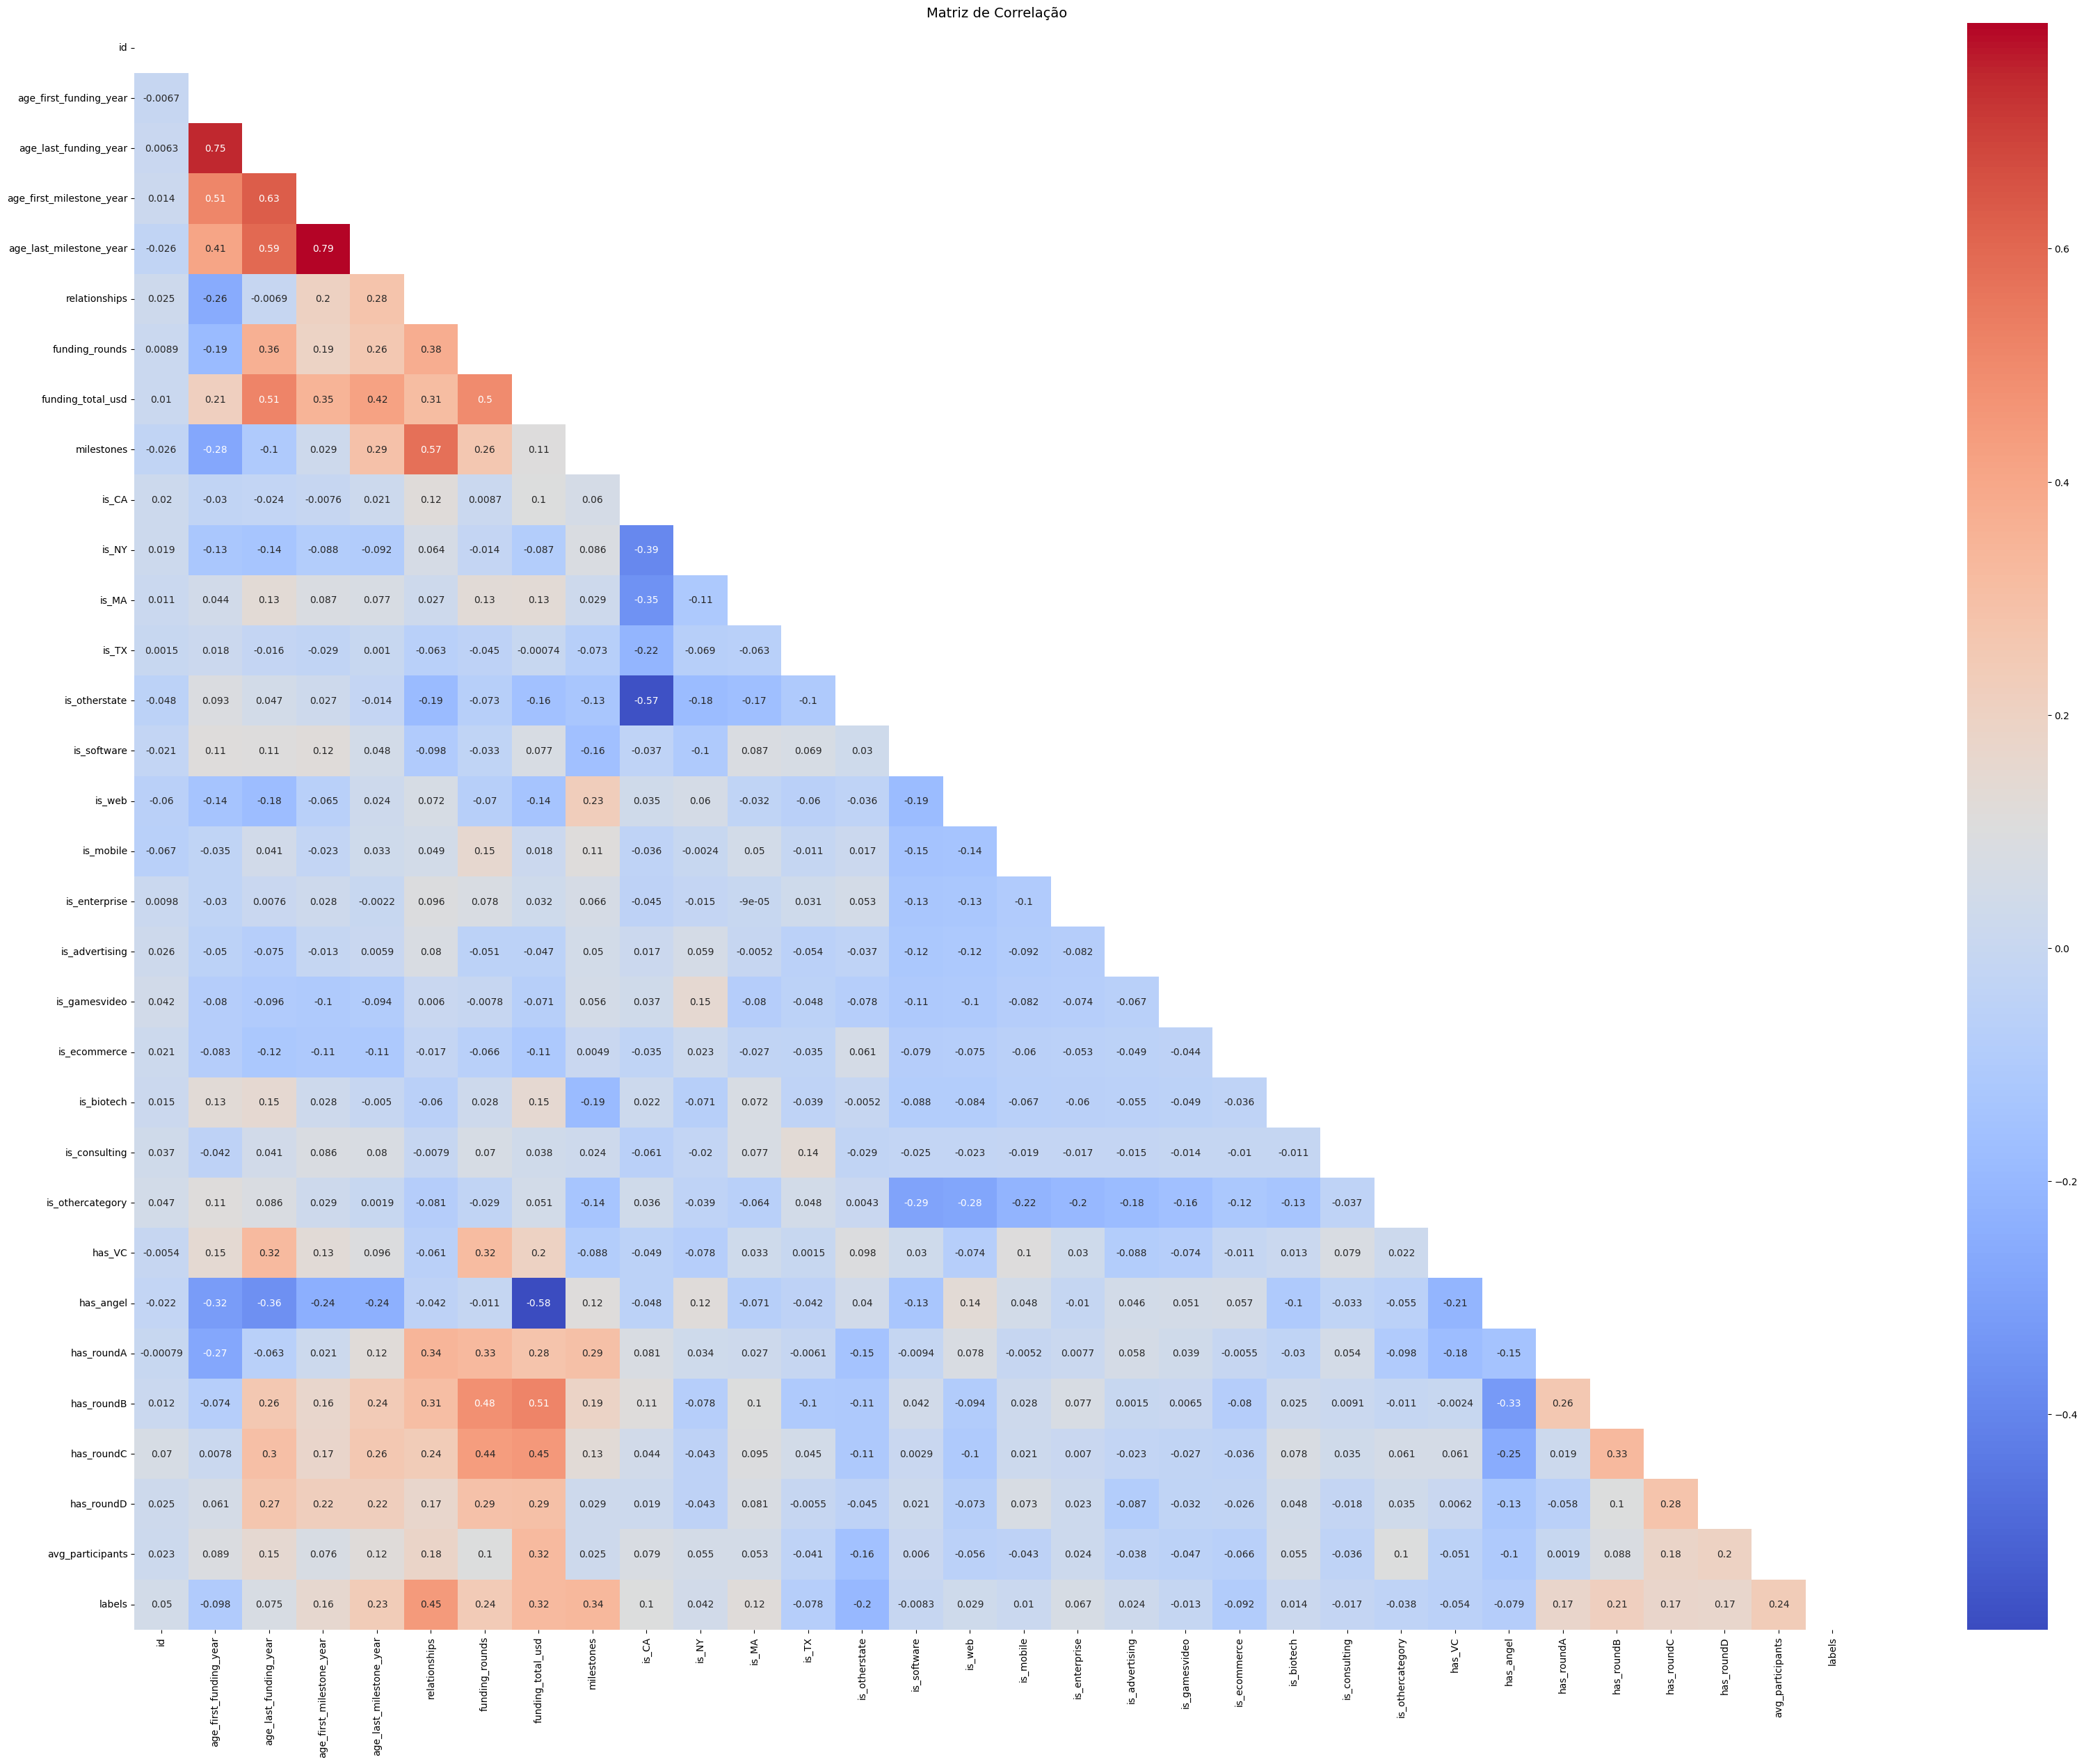

In [28]:
# Matriz de correlação só para numéricas
corr = train_data.select_dtypes(include=["number"]).corr()

# Plot mais limpo
plt.figure(figsize=(40, 30))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, cmap="coolwarm", annot=True, mask=mask)
plt.title("Matriz de Correlação", fontsize=14)
plt.show()

In [29]:
# Filtra só as colunas numéricas
num_cols = train_data.select_dtypes(include="number")

# Calcula correlação só com elas
corr = num_cols.corr()

# Correlação das variáveis com o target
corr_target = corr["labels"].sort_values(ascending=False)

print("Correlação com o sucesso (labels):\n")
print(corr_target)

Correlação com o sucesso (labels):

labels                      1.000000
relationships               0.446120
milestones                  0.335149
funding_total_usd           0.321465
funding_rounds              0.240108
avg_participants            0.238025
age_last_milestone_year     0.234071
has_roundB                  0.214299
has_roundC                  0.172943
has_roundA                  0.171953
has_roundD                  0.166680
age_first_milestone_year    0.156061
is_MA                       0.116638
is_CA                       0.101427
age_last_funding_year       0.075331
is_enterprise               0.067350
id                          0.050312
is_NY                       0.042035
is_web                      0.029337
is_advertising              0.023952
is_biotech                  0.013831
is_mobile                   0.010135
is_software                -0.008263
is_gamesvideo              -0.013120
is_consulting              -0.017149
is_othercategory           -0.038491
ha

Com base na análise, foi selecionado as features numéricas mais relevantes, priorizando aquelas com correlação mais alta com a variável alvo e evitando redundância. Essas serão utilizadas no pipeline de pré-processamento e modelagem.

In [30]:
selected_features = [
    "age_last_milestone_year",
    "age_first_milestone_year"
    "age_last_funding_year",
    "age_first_funding_year",
    "relationships",
    "milestones",
    "funding_rounds",
    "has_roundB",
    "avg_participants",
    "funding_total_usd",
    "has_roundA",
    "is_CA"
]

**Definindo Colunas Numéricas e Categóricas**

Para construir o pipeline, é necessário separar colunas numéricas e categóricas, aplicando transformações adequadas a cada tipo.

- Variáveis numéricas serão padronizadas com StandardScaler.

- Variáveis categóricas serão transformadas em dummies com OneHotEncoder, permitindo que algoritmos lidem corretamente com categorias sem ordem.

In [31]:
# --- Separar colunas ---
numeric_features = [
    "relationships",
    "milestones",
    "age_last_milestone_year",
    "funding_rounds",
    "has_roundB",
    "age_first_milestone_year",
    "avg_participants",
    "funding_total_usd",
    "has_roundA",
    "age_last_funding_year",
    "is_CA"
]

# Pega automaticamente as categóricas que ficaram de fora
categorical_features = [
    col for col in train_data.columns 
    if col not in numeric_features + ["labels", "id"]
]

print("Numéricas:", numeric_features)
print("Categóricas:", categorical_features)

Numéricas: ['relationships', 'milestones', 'age_last_milestone_year', 'funding_rounds', 'has_roundB', 'age_first_milestone_year', 'avg_participants', 'funding_total_usd', 'has_roundA', 'age_last_funding_year', 'is_CA']
Categóricas: ['age_first_funding_year', 'is_NY', 'is_MA', 'is_TX', 'is_otherstate', 'category_code', 'is_software', 'is_web', 'is_mobile', 'is_enterprise', 'is_advertising', 'is_gamesvideo', 'is_ecommerce', 'is_biotech', 'is_consulting', 'is_othercategory', 'has_VC', 'has_angel', 'has_roundC', 'has_roundD', 'faixa_funding', 'rel_group', 'funding_age_group']


Agora há uma distinção clara entre colunas numéricas e categóricas, permitindo que cada uma receba o tratamento adequado no pipeline.

**Construção do Pipeline de Pré-Processamento**

Para garantir que todas as transformações sejam aplicadas de forma consistente no treino e teste, criou-se pipelines separados para numéricas e categóricas, combinando-os em um ColumnTransformer.

- numeric_transformer: padroniza todas as variáveis numéricas.

- categorical_transformer: aplica One-Hot Encoding em todas as variáveis categóricas.

- preprocessor: aplica os dois transformers no dataset completo, mantendo a consistência entre treino e teste.

In [32]:
# --- Transformações ---
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])


categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])


# --- ColumnTransformer ---
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

O pipeline preprocessor padroniza variáveis numéricas, transforma categóricas em dummies e garante que o mesmo processo seja aplicado no conjunto de teste, mantendo integridade e consistência dos dados.

### Feature Engineering

Para melhorar a capacidade preditiva do modelo, novas features derivadas das colunas existentes foram criadas. Essas variáveis representam informações combinadas ou normalizadas, que capturam melhor o histórico e a maturidade das startups.  

Entre as principais criações estão:  
- Duração total de captação de recursos (`funding_duration`)  
- Relação de relacionamentos por rodada de investimento (`relationships_per_round`)  
- Score de maturidade (`maturity_score`) combinando funding, relacionamentos e milestones  
- Valores médios de financiamento por rodada e por relacionamento  
- Proporção de milestones e participantes por unidade de tempo ou rodada 

In [33]:
# 1. funding_duration
train_data["funding_duration"] = (train_data["age_last_funding_year"] - train_data["age_first_funding_year"]).clip(lower=0)
test_data["funding_duration"]  = (test_data["age_last_funding_year"] - test_data["age_first_funding_year"]).clip(lower=0)

# 2. avg_relationships_per_round
train_data["avg_relationships_per_round"] = train_data["relationships"] / (train_data["funding_rounds"] + 1)
test_data["avg_relationships_per_round"]  = test_data["relationships"] / (test_data["funding_rounds"] + 1)

# 3. maturity_score (normalização)
for col in ["funding_rounds", "relationships", "milestones"]:
    max_val = train_data[col].max()
    train_data[f"{col}_norm"] = train_data[col] / max_val
    test_data[f"{col}_norm"]  = test_data[col] / max_val

train_data["maturity_score"] = (
    train_data["funding_rounds_norm"] * 0.4 +
    train_data["relationships_norm"] * 0.3 +
    train_data["milestones_norm"] * 0.3
)
test_data["maturity_score"] = (
    test_data["funding_rounds_norm"] * 0.4 +
    test_data["relationships_norm"] * 0.3 +
    test_data["milestones_norm"] * 0.3
)

# 4. avg_funding_per_round e funding_per_relationship
train_data["avg_funding_per_round"] = train_data["funding_total_usd"] / (train_data["funding_rounds"] + 1)
test_data["avg_funding_per_round"]  = test_data["funding_total_usd"] / (test_data["funding_rounds"] + 1)

train_data["funding_per_relationship"] = train_data["funding_total_usd"] / (train_data["relationships"] + 1)
test_data["funding_per_relationship"]  = test_data["funding_total_usd"] / (test_data["relationships"] + 1)

# 5. milestones_per_funding_year
train_data["milestones_per_year"] = train_data["milestones"] / (train_data["funding_duration"] + 1)
test_data["milestones_per_year"]  = test_data["milestones"] / (test_data["funding_duration"] + 1)

# 6. participants_per_round
train_data["participants_per_round"] = train_data["avg_participants"] / (train_data["funding_rounds"] + 1)
test_data["participants_per_round"]  = test_data["avg_participants"] / (test_data["funding_rounds"] + 1)

Após a criação dessas novas features, o dataset contém informações adicionais que **capturam relações entre funding, milestones, participantes e relacionamentos** das startups.  

Essas variáveis derivadas podem melhorar a capacidade do modelo de identificar padrões e prever o sucesso das empresas, complementando as features originais.  

Em seguida, **uma nova análise de correlação** foi feita para avaliar a importância das features finais antes de construir o modelo.

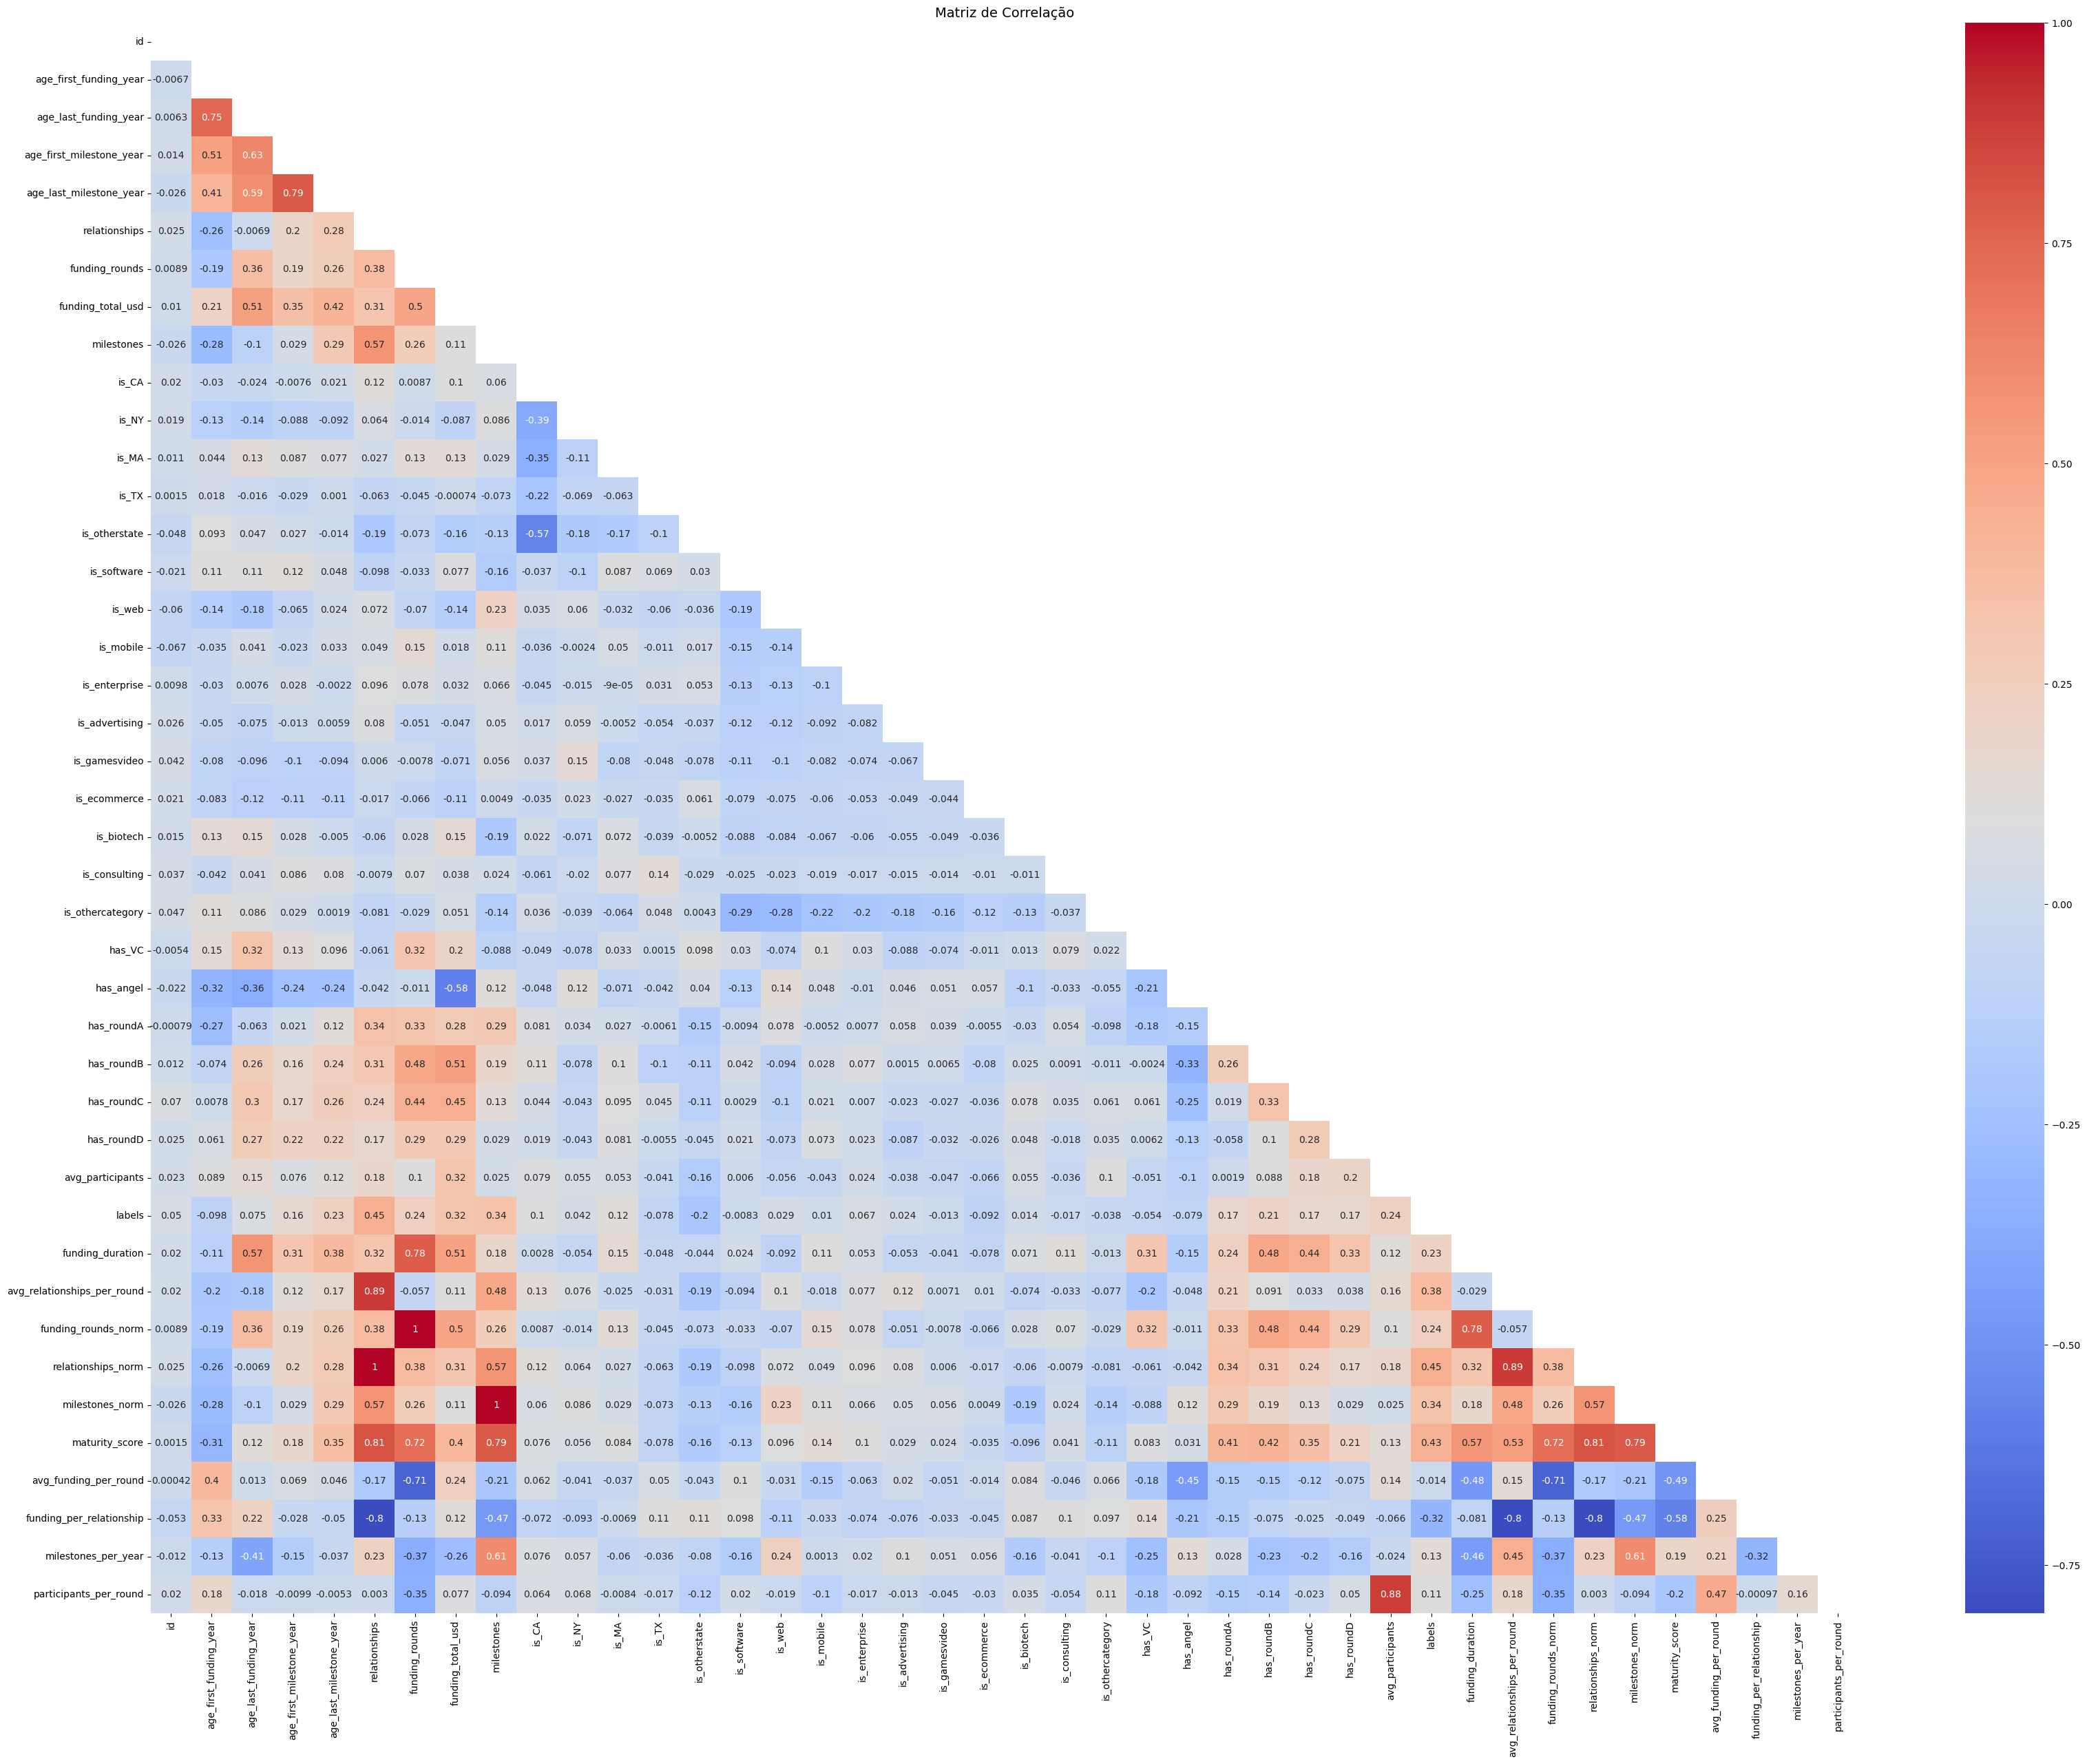

In [34]:
# Matriz de correlação só para numéricas
corr = train_data.select_dtypes(include=["number"]).corr()

# Plot mais limpo
plt.figure(figsize=(40, 30))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, cmap="coolwarm", annot=True, mask=mask)
plt.title("Matriz de Correlação", fontsize=14)
plt.show()

In [35]:
# Filtra só as colunas numéricas
num_cols = train_data.select_dtypes(include="number")

# Calcula correlação só com elas
corr = num_cols.corr()

# Correlação das variáveis com o target
corr_target = corr["labels"].sort_values(ascending=False)

print("Correlação com o sucesso (labels):\n")
print(corr_target)

Correlação com o sucesso (labels):

labels                         1.000000
relationships                  0.446120
relationships_norm             0.446120
maturity_score                 0.431514
avg_relationships_per_round    0.376030
milestones                     0.335149
milestones_norm                0.335149
funding_total_usd              0.321465
funding_rounds_norm            0.240108
funding_rounds                 0.240108
avg_participants               0.238025
age_last_milestone_year        0.234071
funding_duration               0.229231
has_roundB                     0.214299
has_roundC                     0.172943
has_roundA                     0.171953
has_roundD                     0.166680
age_first_milestone_year       0.156061
milestones_per_year            0.128504
is_MA                          0.116638
participants_per_round         0.106586
is_CA                          0.101427
age_last_funding_year          0.075331
is_enterprise                  0.067350
id  

Com base na matriz de correlação e em testes que avaliavam o impacto de cada feature na acurácia do modelo, as seguintes variáveis foram selecionadas para a modelagem.

In [36]:
selected_features = [
    "maturity_score",
    "relationships",
    "milestones",
    "age_last_milestone_year",
    "funding_rounds",
    "has_roundB",
    "age_first_milestone_year",
    "avg_participants",
    "funding_total_usd",
    "has_roundA",
    "age_last_funding_year",
    "is_CA"
]

A seguir, o pipeline de pré-processamento foi atualizado.

Este pipeline garante que o mesmo tratamento seja aplicado de forma consistente em todos os dados, evitando vazamento de informação e preparando o dataset para a etapa de modelagem.

In [37]:
numeric_features = [
    "maturity_score",
    "relationships_norm",
    "milestones",
    "avg_relationships_per_round",
    "age_last_milestone_year",
    "funding_rounds",
    "age_first_milestone_year",
    "age_first_funding_year",
    "avg_participants",
    "funding_total_usd",
    "funding_duration"
]

# Colunas categóricas que existem
categorical_features = [
    "has_roundB",
    "has_roundA",
    "is_CA"
]

preprocessor_final = ColumnTransformer(transformers=[
    ("num", StandardScaler(), numeric_features),
    ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# **Modelagem**

### Divisão de Dados

In [38]:
# Features e target
X = train_data.drop(columns=["labels", "id"])  # Remove target e id
y = train_data["labels"]                       # Target

# Teste (sem target)
X_test = test_data.drop(columns=["id"])        # Apenas features, sem id

print("Dimensão de X (numéricas):", X.shape)
print("Dimensão de X_test (numéricas):", X_test.shape)
print("Dimensão de y:", y.shape)

Dimensão de X (numéricas): (646, 44)
Dimensão de X_test (numéricas): (277, 41)
Dimensão de y: (646,)


### Construção do Modelo

Após a seleção das features e separação de X e y, o pipeline de pré-processamento será aplicado para transformar os dados e deixá-los prontos para o modelo.

Para este desafio de previsão de sucesso de startups, foi escolhido modelar usando **Random Forest**, uma vez que é:

- Robusto a outliers e escalas diferentes.

- Capaz de lidar com um mix de variáveis numéricas e categóricas.

- Interpretável via importância de features.

In [39]:
# Pipeline
rf_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor_final),
    ("classifier", RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    ))
])

# Cross-validation com múltiplas métricas
scoring = ['accuracy', 'precision', 'recall', 'f1']
cv_results = cross_validate(rf_pipeline, X, y, cv=5, scoring=scoring, n_jobs=-1)

# Mostrar resultados médios
for metric in scoring:
    mean_score = cv_results[f'test_{metric}'].mean()
    std_score = cv_results[f'test_{metric}'].std()
    print(f"{metric.capitalize()}: {mean_score:.4f} ± {std_score:.4f}")

Accuracy: 0.7770 ± 0.0368
Precision: 0.7820 ± 0.0338
Recall: 0.9116 ± 0.0314
F1: 0.8413 ± 0.0245


O modelo apresentou desempenho consistente nas métricas avaliadas. A acurácia média foi de 77,7%, indicando que a maior parte das previsões está correta. O recall elevado (91,2%) sugere que o modelo consegue identificar corretamente a maioria dos casos positivos, enquanto a precisão de 78,2% mostra que a proporção de falsos positivos é relativamente baixa. O F1-score de 84,1% reflete um bom equilíbrio entre precisão e recall, evidenciando a robustez do modelo.

A seguir, o modelo final foi treinado e avaliado, e um arquivo de submissão para o Kaggle foi gerado.

In [40]:
rf_pipeline.fit(X, y)

# Previsões no conjunto de teste
y_test_pred = rf_pipeline.predict(X_test)

# Preparar arquivo de submissão
submission = pd.DataFrame({
    "id": test_data["id"],
    "labels": y_test_pred
})

submission.to_csv("submission.csv", index=False)

Foi realizada uma tentativa de otimização de hiperparâmetros utilizando Grid Search com validação cruzada estratificada. No entanto, essa abordagem não trouxe melhoria significativa na acurácia do modelo, apresentou problemas em algumas variáveis e demandava um tempo de execução elevado. Por esses motivos, decidiu-se retirar o Grid Search e seguir com o modelo base previamente definido.

In [41]:
""""
# --- Definir o modelo base ---
rf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(random_state=42, n_jobs=-1))
])

# --- Espaço de busca de hiperparâmetros ---
param_grid = {
    "classifier__n_estimators": [150, 200, 300],   # número de árvores
    "classifier__max_depth": [10, 20, 30, None],   # profundidade máxima
    "classifier__min_samples_split": [2, 5, 10],   # min. amostras p/ split
    "classifier__min_samples_leaf": [1, 2, 4],     # min. amostras na folha
    "classifier__max_features": ["sqrt", "log2"],  # nº máx. de features em cada split
    "classifier__bootstrap": [True, False]         # usar ou não bootstrap
}

# --- Cross-validation estratificada (importante p/ desbalanceamento) ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --- Grid Search ---
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=cv,
    scoring="accuracy",    # pode trocar por "f1", "accuracy" etc
    n_jobs=-1,
    verbose=2
)

# --- Rodar busca ---
grid_search.fit(X, y)

# --- Melhor modelo encontrado ---
print("Melhores hiperparâmetros:", grid_search.best_params_)
print("Melhor Accuracy:", grid_search.best_score_)

# --- Usar modelo otimizado ---
best_model = grid_search.best_estimator_
"""

'"\n# --- Definir o modelo base ---\nrf = Pipeline(steps=[\n    ("preprocessor", preprocessor),\n    ("classifier", RandomForestClassifier(random_state=42, n_jobs=-1))\n])\n\n# --- Espaço de busca de hiperparâmetros ---\nparam_grid = {\n    "classifier__n_estimators": [150, 200, 300],   # número de árvores\n    "classifier__max_depth": [10, 20, 30, None],   # profundidade máxima\n    "classifier__min_samples_split": [2, 5, 10],   # min. amostras p/ split\n    "classifier__min_samples_leaf": [1, 2, 4],     # min. amostras na folha\n    "classifier__max_features": ["sqrt", "log2"],  # nº máx. de features em cada split\n    "classifier__bootstrap": [True, False]         # usar ou não bootstrap\n}\n\n# --- Cross-validation estratificada (importante p/ desbalanceamento) ---\ncv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)\n\n# --- Grid Search ---\ngrid_search = GridSearchCV(\n    estimator=rf,\n    param_grid=param_grid,\n    cv=cv,\n    scoring="accuracy",    # pode trocar 

In [42]:
"""
# Definir métricas
scoring = ["accuracy", "precision", "recall", "f1", "roc_auc"]

# Cross-validation
cv_results = cross_validate(
    best_model,
    X,
    y,
    cv=5,
    scoring=scoring,
    return_train_score=True
)

# Organizar em DataFrame
df_scores = pd.DataFrame({
    "Treino (médio)": [cv_results[f"train_{m}"].mean() for m in scoring],
    "Treino (std)": [cv_results[f"train_{m}"].std() for m in scoring],
    "Teste (médio)": [cv_results[f"test_{m}"].mean() for m in scoring],
    "Teste (std)": [cv_results[f"test_{m}"].std() for m in scoring],
}, index=scoring)

print("\n===== Resultados Cross-Validation =====\n")
for metric in scoring:
    print(f"{metric.upper()}")
    print(f"  Treino -> {df_scores.loc[metric, 'Treino (médio)']:.4f} ± {df_scores.loc[metric, 'Treino (std)']:.4f}")
    print(f"  Teste  -> {df_scores.loc[metric, 'Teste (médio)']:.4f} ± {df_scores.loc[metric, 'Teste (std)']:.4f}")
    print()
"""

'\n# Definir métricas\nscoring = ["accuracy", "precision", "recall", "f1", "roc_auc"]\n\n# Cross-validation\ncv_results = cross_validate(\n    best_model,\n    X,\n    y,\n    cv=5,\n    scoring=scoring,\n    return_train_score=True\n)\n\n# Organizar em DataFrame\ndf_scores = pd.DataFrame({\n    "Treino (médio)": [cv_results[f"train_{m}"].mean() for m in scoring],\n    "Treino (std)": [cv_results[f"train_{m}"].std() for m in scoring],\n    "Teste (médio)": [cv_results[f"test_{m}"].mean() for m in scoring],\n    "Teste (std)": [cv_results[f"test_{m}"].std() for m in scoring],\n}, index=scoring)\n\nprint("\n===== Resultados Cross-Validation =====\n")\nfor metric in scoring:\n    print(f"{metric.upper()}")\n    print(f"  Treino -> {df_scores.loc[metric, \'Treino (médio)\']:.4f} ± {df_scores.loc[metric, \'Treino (std)\']:.4f}")\n    print(f"  Teste  -> {df_scores.loc[metric, \'Teste (médio)\']:.4f} ± {df_scores.loc[metric, \'Teste (std)\']:.4f}")\n    print()\n'